In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/dataset-for-gnn-array/dic_array.csv


In [2]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings

# Set env
plt.style.use('seaborn')
sns.set(font_scale=2.5)

warnings.filterwarnings('ignore')

%matplotlib inline

/tmp/ipykernel_18/2115881946.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# Load csv files
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

## 1. View Train/Test set

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
col_names = df_train.columns.values
col_type = ['integer(x)', 'integer(target)', 'integer(category)', 'string', 'string(binary)', 'integer', 'integer', 'integer',   
               'string(string+integer)', 'integer', 'string', 'string']
col_contents = ['Passenger Number', 'Survival Status', 'Seat Class', 'Name', 'Gender', 'Age', 'Siblings/Spouse', 
         'Parents/Children', 'Ticket Number', 'Fare', 'Cabin Number', 'Embarkation Port']

col_description = pd.DataFrame({'content': col_contents, 'type': col_type}, index=col_names)
col_description

,content,type
PassengerId,승객번호,integer(x)
Survived,생존여부,integer(target)
Pclass,좌석구분,integer(category)
Name,이름,string
Sex,성별,string(binary)
Age,나이,integer
SibSp,형제/배우자,integer
Parch,부모/아이,integer
Ticket,티켓번호,string(string+integer)
Fare,요금,integer


In [8]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- 승객의 수 : 891
- 생존률 : 약 38.4%
- 연령 : 0.42 ~ 80세까지 
- 가족(sibsp+parch) : 0 ~ 14명?
- 요금 : 0 ~ 512.329200
- train/test set 분포는 비슷

In [9]:
## df_test set describe
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [10]:
## null data check

for col in df_train.columns:
    msg = f'column: {col:>10}\t Percent of null value: {df_train[col].isnull().sum()/df_train.shape[0] * 100:.2f}%'
    print(msg)

column: PassengerId	 Percent of null value: 0.00%
column:   Survived	 Percent of null value: 0.00%
column:     Pclass	 Percent of null value: 0.00%
column:       Name	 Percent of null value: 0.00%
column:        Sex	 Percent of null value: 0.00%
column:        Age	 Percent of null value: 19.87%
column:      SibSp	 Percent of null value: 0.00%
column:      Parch	 Percent of null value: 0.00%
column:     Ticket	 Percent of null value: 0.00%
column:       Fare	 Percent of null value: 0.00%
column:      Cabin	 Percent of null value: 77.10%
column:   Embarked	 Percent of null value: 0.22%


In [11]:
for col in df_test.columns:
    msg = f'column: {col:>10}\t Percent of null value: {df_test[col].isnull().sum()/df_test.shape[0] * 100:.2f}%'
    print(msg)

column: PassengerId	 Percent of null value: 0.00%
column:     Pclass	 Percent of null value: 0.00%
column:       Name	 Percent of null value: 0.00%
column:        Sex	 Percent of null value: 0.00%
column:        Age	 Percent of null value: 20.57%
column:      SibSp	 Percent of null value: 0.00%
column:      Parch	 Percent of null value: 0.00%
column:     Ticket	 Percent of null value: 0.00%
column:       Fare	 Percent of null value: 0.24%
column:      Cabin	 Percent of null value: 78.23%
column:   Embarked	 Percent of null value: 0.00%


Both the train set and test set have null values for age (1%) and cabin (77-8%).

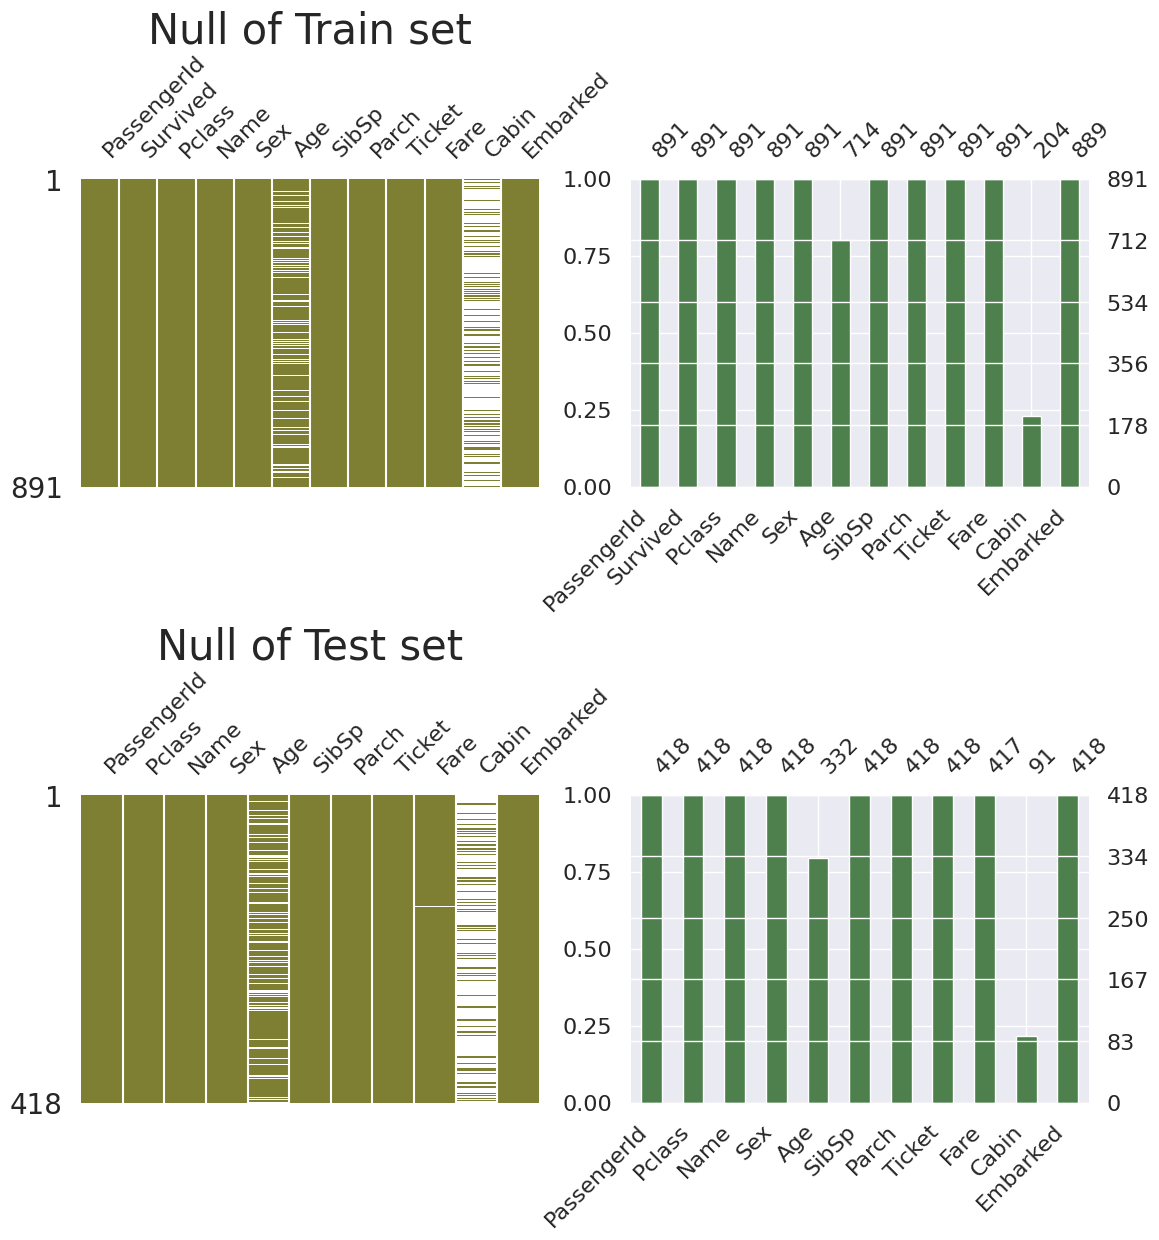

In [12]:
## null check visualization using missingno

f, ax = plt.subplots(2, 2, figsize=(13, 12))
msno.matrix(df=df_train.iloc[:, :], color=(0.5, 0.5, 0.2), ax=ax[0, 0])
msno.bar(df=df_train.iloc[:, :], color=(0.3, 0.5, 0.3), ax=ax[0, 1])
msno.matrix(df=df_test.iloc[:, :], color=(0.5, 0.5, 0.2), ax=ax[1, 0])
msno.bar(df=df_test.iloc[:, :], color=(0.3, 0.5, 0.3), ax=ax[1, 1])
ax[0, 0].set_title("Null of Train set")
ax[1, 0].set_title("Null of Test set")

plt.subplots_adjust(hspace=1)
plt.show()

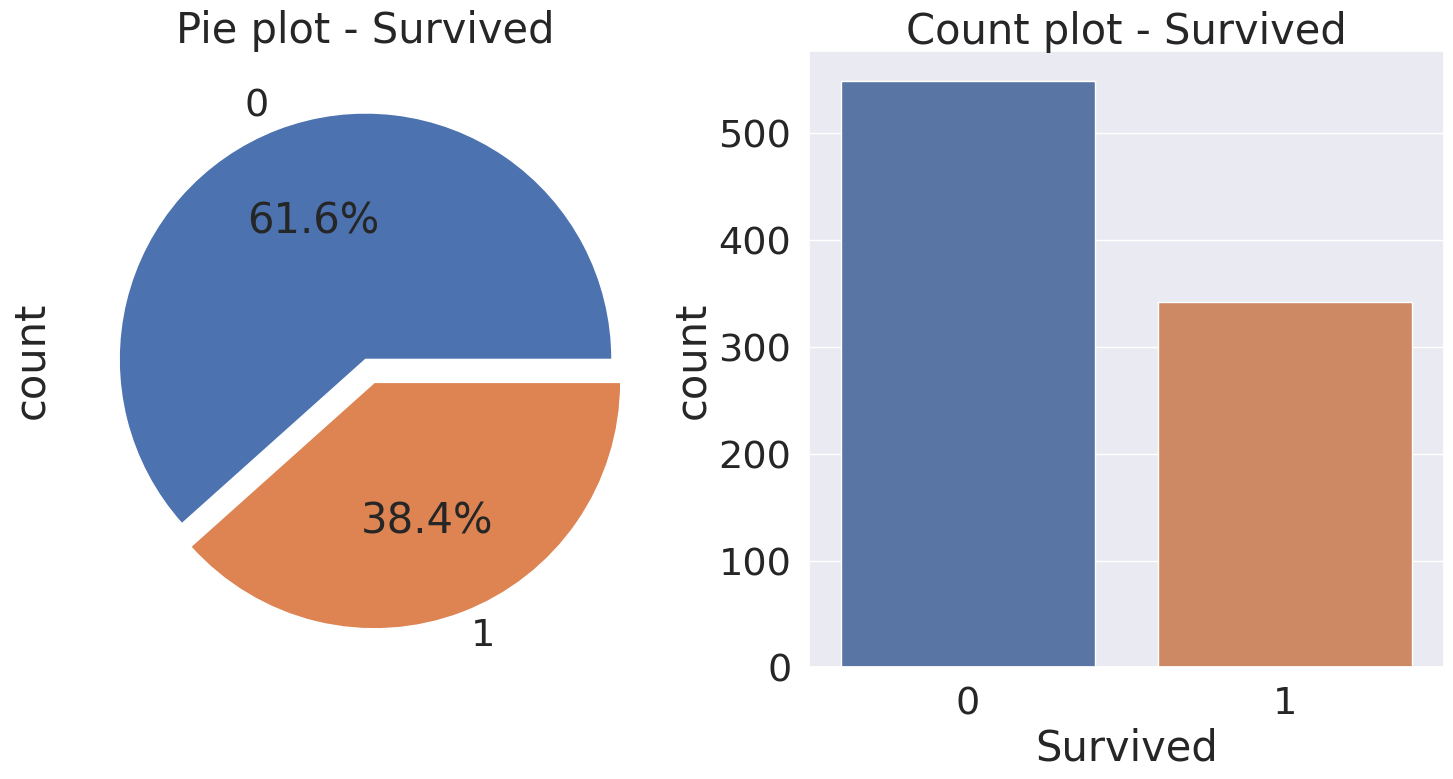

In [13]:
# Target(Survived:생존여부) distribution check

f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', 
                            ax=ax[0])
sns.countplot(x='Survived', data=df_train, ax=ax[1])

ax[0].set_title('Pie plot - Survived')
ax[1].set_title('Count plot - Survived')

plt.show()

## 2. Survived check of each features
### 2.1 pclass

In [14]:
feature_names = col_names[2:]
target_name = 'Survived'
feature_names

array(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'], dtype=object)

In [15]:
# pclass 별 탑승인원
df_train[[feature_names[0], target_name]].groupby([feature_names[0]], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [16]:
# pclass 별 생존인원
df_train[[feature_names[0], target_name]].groupby([feature_names[0]], as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


In [17]:
pd.crosstab(df_train[feature_names[0]], df_train[target_name], 
            margins=True).style.background_gradient(cmap='YlGnBu')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


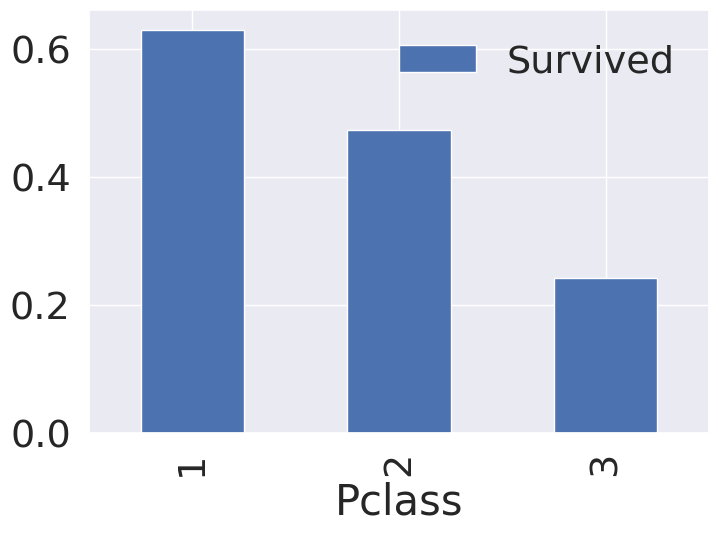

In [18]:
# 각 Pclass별 생존률
df_train[[feature_names[0], target_name]].groupby([feature_names[0]], 
          as_index=True).mean().sort_values(by=target_name, ascending=False).plot.bar()
plt.show()

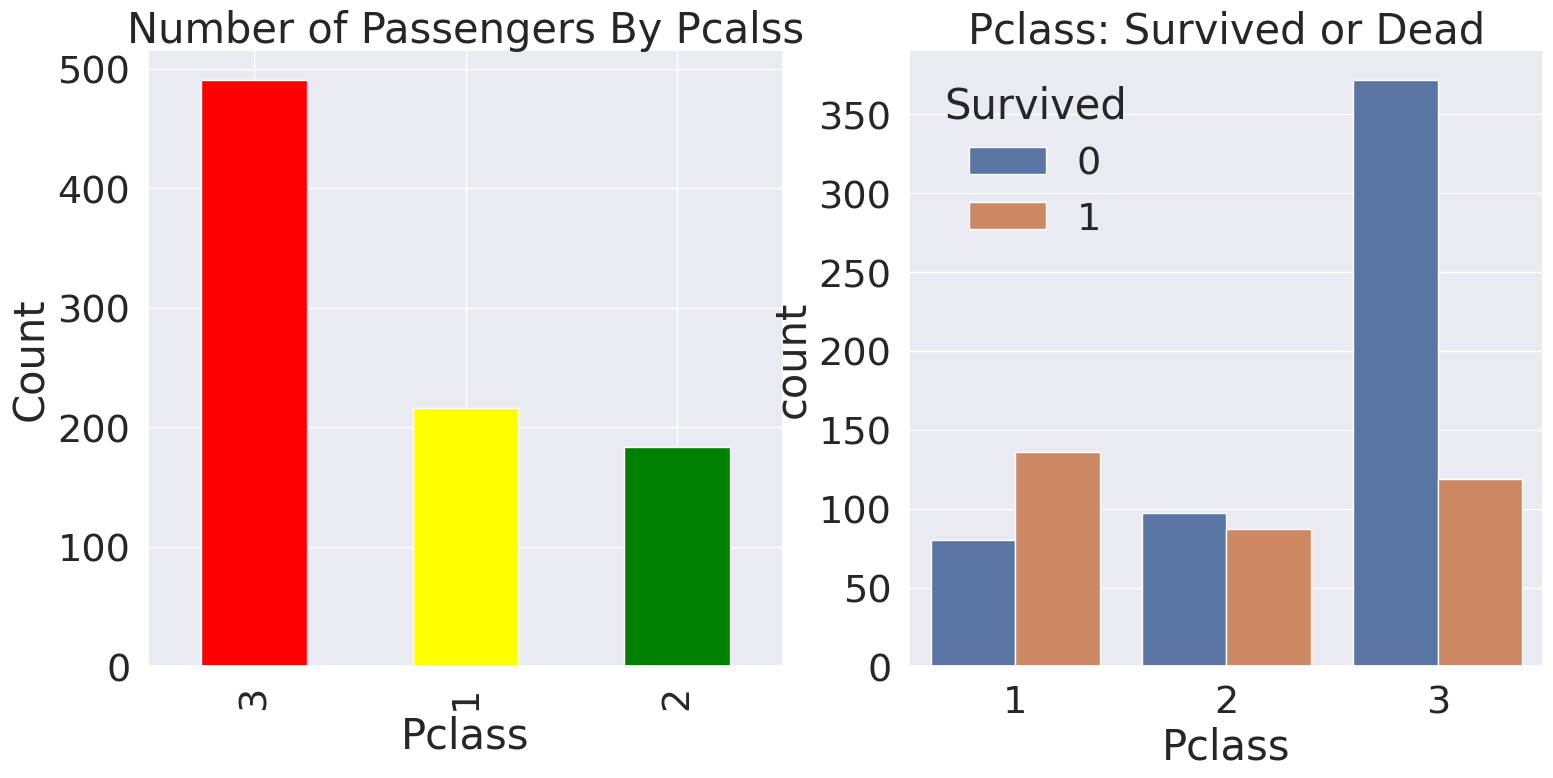

In [19]:
y_position = 1.2
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train[feature_names[0]].value_counts().plot.bar(color=['red', 
          'yellow', 'green'], ax=ax[0])
sns.countplot(x=feature_names[0], hue=target_name, data=df_train, ax=ax[1])

ax[0].set_title('Number of Passengers By Pcalss')
ax[0].set_ylabel('Count')
ax[1].set_title("Pclass: Survived or Dead")

plt.show()

Survival rate is higher as Pclass increases.

Although the majority of passengers were in the third class, the survival rate is higher as Pclass increases.

### 2.2. Sex

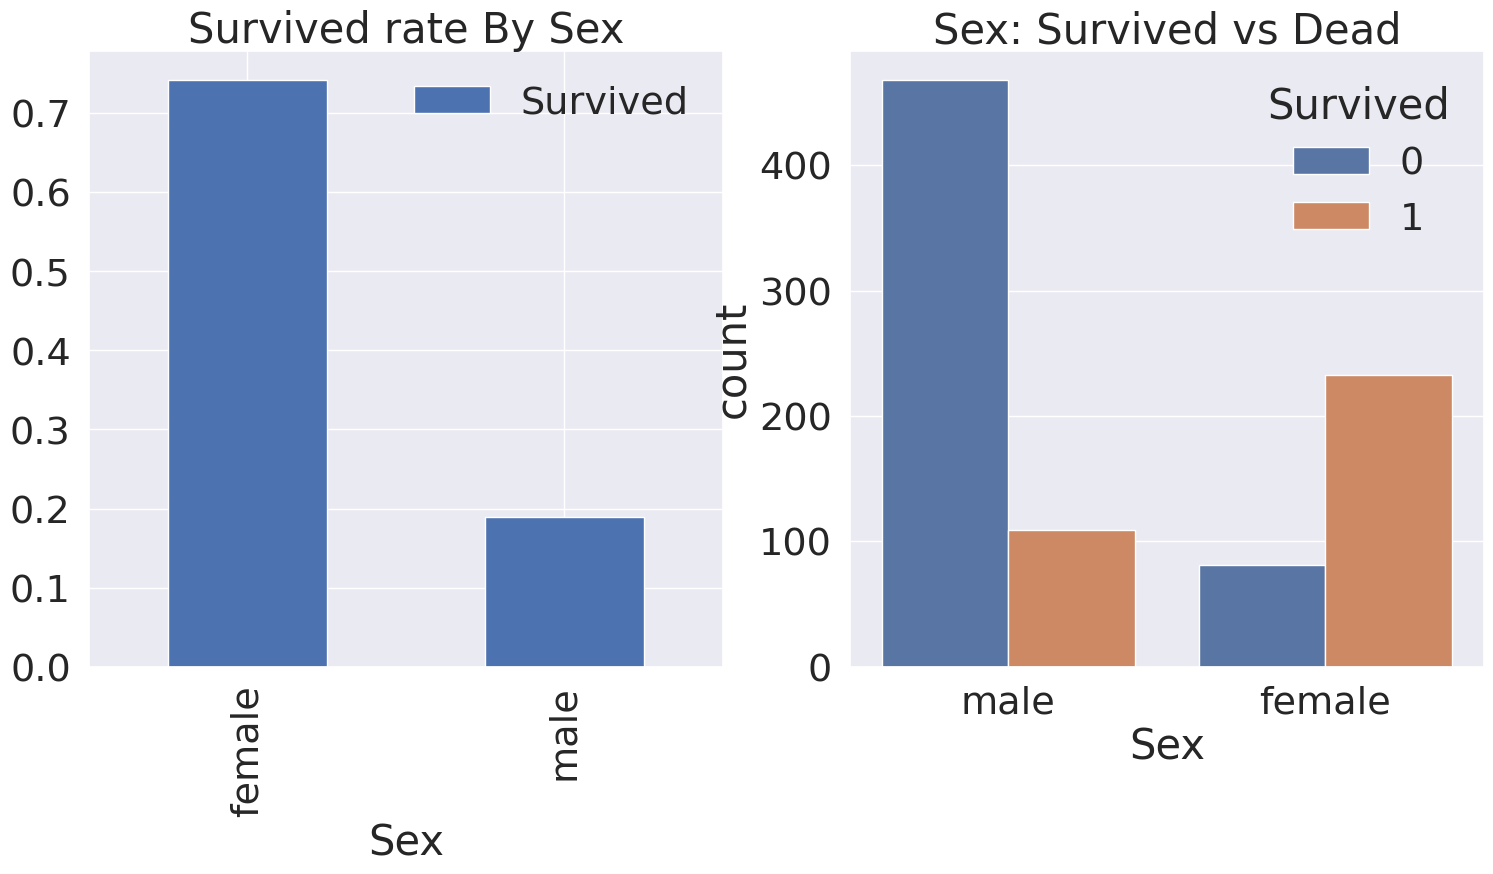

In [20]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train[[feature_names[2], target_name]].groupby(feature_names[2], as_index=True).mean().plot.bar(ax=ax[0])
sns.countplot(x=feature_names[2], hue=target_name, data=df_train, ax=ax[1])

ax[0].set_title('Survived rate By Sex')
ax[1].set_title("Sex: Survived vs Dead")

plt.show()

In [21]:
df_train[[feature_names[2], target_name]].groupby(feature_names[2], 
        as_index=False).mean().sort_values(by=target_name, ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


The survival rate is overwhelmingly higher for females

In [22]:
pd.crosstab(df_train[feature_names[2]], df_train[target_name], 
           margins=True).style.background_gradient(cmap='YlGn')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


Comparison of two features (Pclass, Sex): The survival rate for females is higher across all Pclass categories

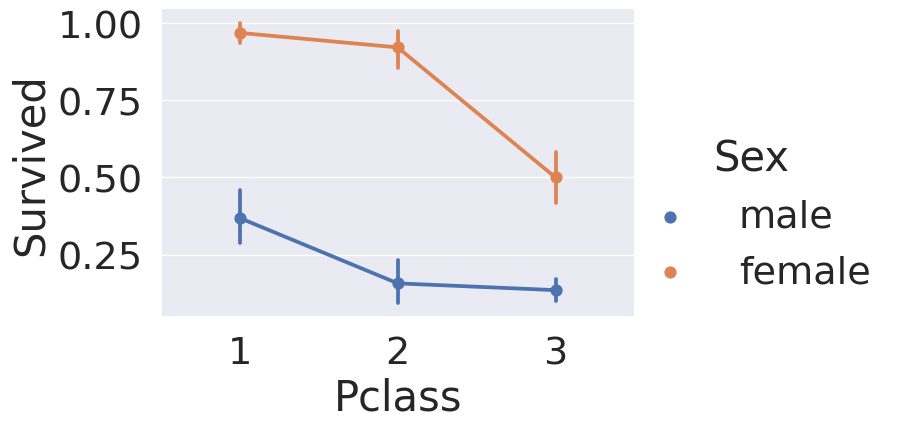

In [23]:
# pclass별 성별 생존률
sns.catplot(x=feature_names[0], y=target_name, hue=feature_names[2], 
            kind='point', data = df_train, aspect=1.5)
plt.show()

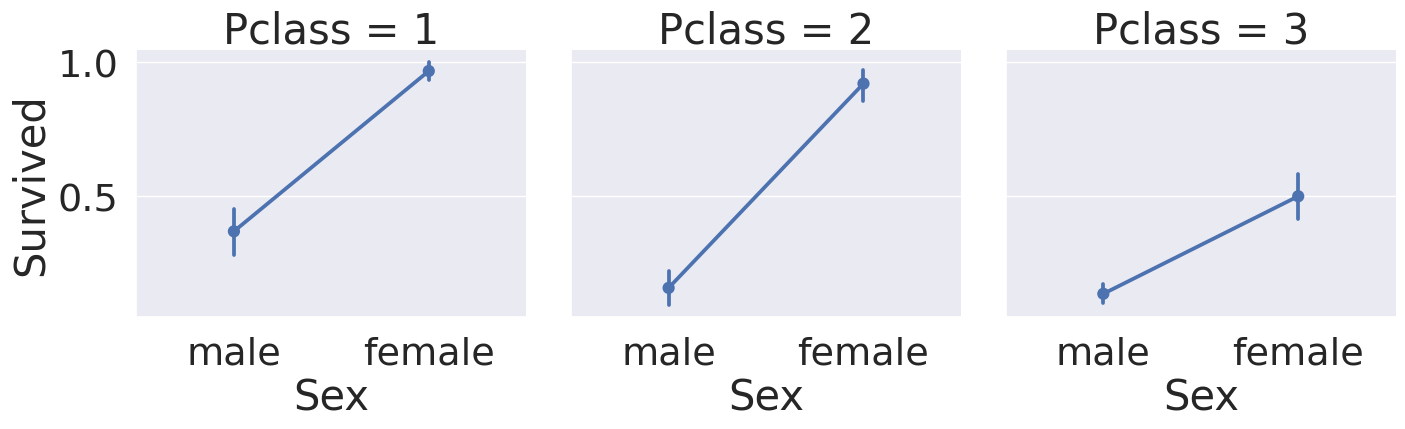

In [24]:
sns.catplot(x=feature_names[2], y=target_name, col=feature_names[0], 
           data=df_train, kind='point', aspect=1)
plt.show()

### 3. Age

In [25]:
print(f'oldest passenger : {df_train[feature_names[3]].max()} age')
print(f'youngest passenger : {df_train[feature_names[3]].min()} age')
print(f'avg age : {df_train[feature_names[3]].mean():.2f} age')

제일 나이 많은 승객 : 80.0 살
제일 나이 어린 승객 : 0.42 살
승객 평균 나이 : 29.70 살


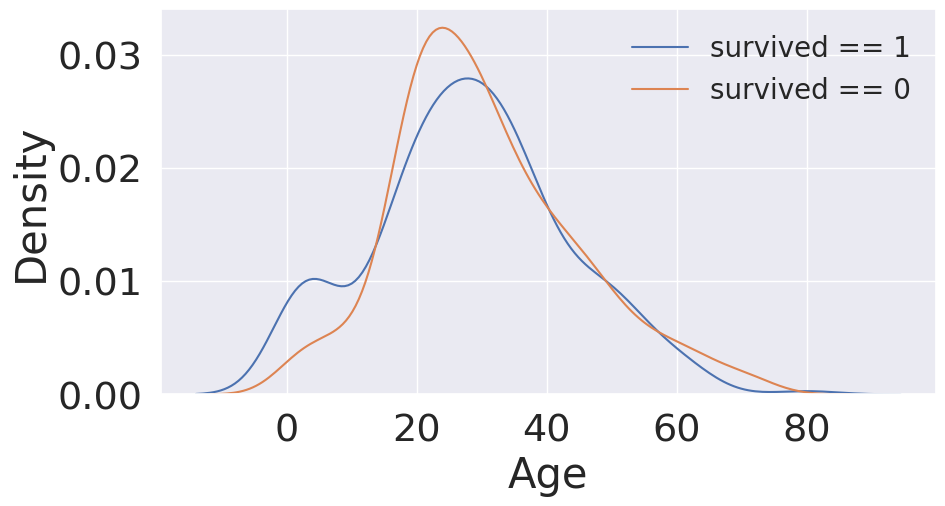

In [26]:
# age histogram

f, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.kdeplot(df_train[df_train[target_name] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train[target_name] == 0]['Age'], ax=ax)
plt.legend(['survived == 1', 'survived == 0'], fontsize='20')
plt.show()

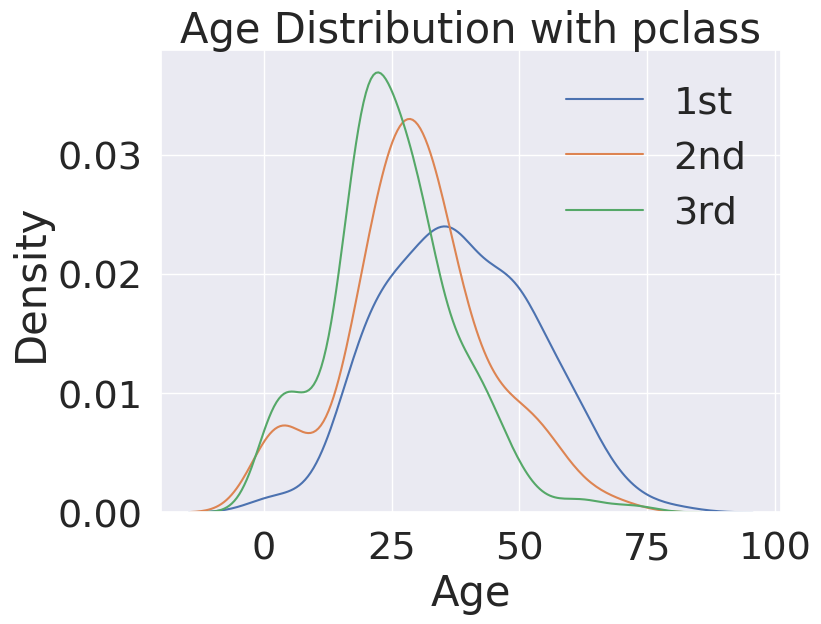

In [27]:
# age distribution with pclass

f, ax = plt.subplots(1, 1, figsize=(8, 6))

for i in range(1, 4):
    sns.kdeplot(df_train[df_train[feature_names[0]] == i]['Age'], ax=ax)

ax.set_title('Age Distribution with pclass')
ax.set_xlabel('Age')
ax.legend(['1st', '2nd', '3rd'])
plt.show()

- The higher the Pclass (1st), the higher the proportion of older people.
- High proportion of young people in low grades

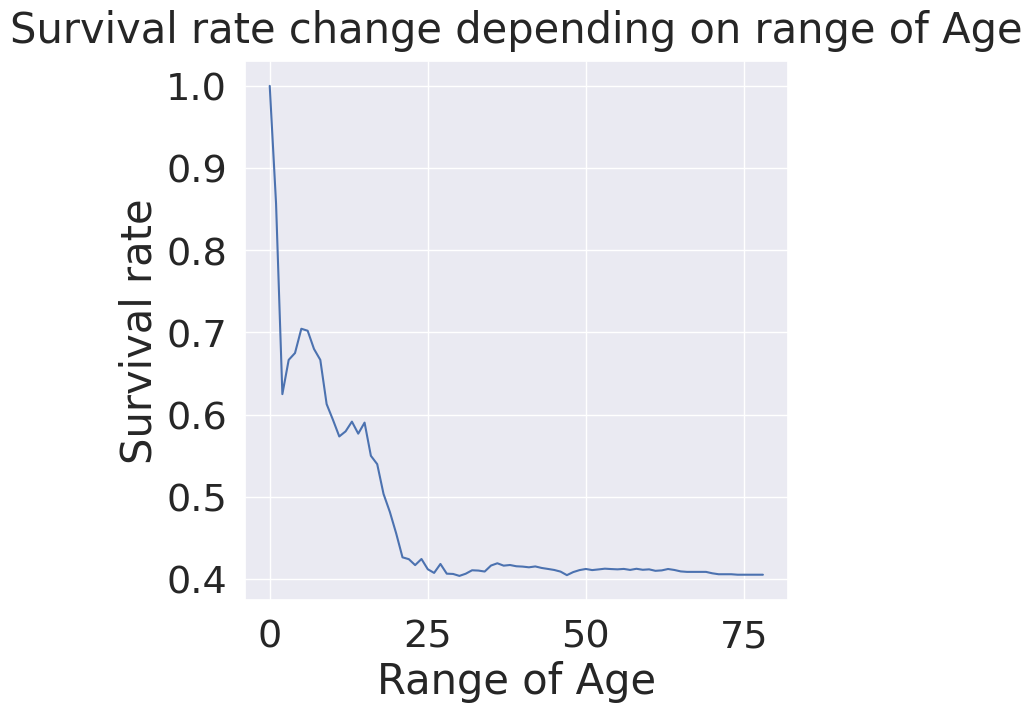

In [28]:
# age cumulative survival graph
cummulate_survival_rate = []

for i in range(1, 80):
    tmp = df_train[df_train['Age'] < i]['Survived'].sum()
    cnt = len(df_train[df_train['Age'] < i])
    cummulate_survival_rate.append(tmp/cnt)

plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_rate)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age')
plt.show()

### 2.4. : Pclass, sex, age

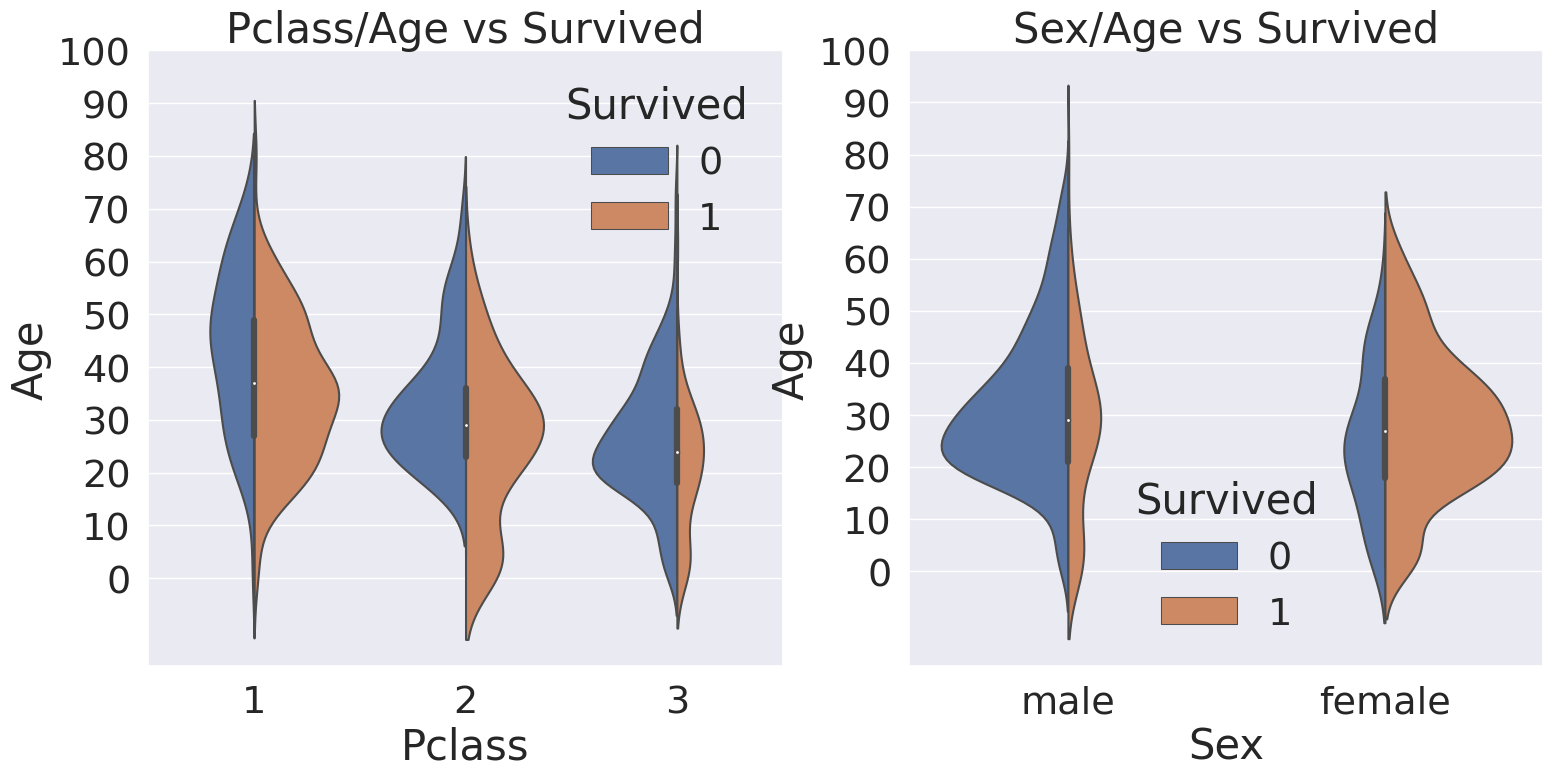

In [29]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.violinplot(x='Pclass', y='Age', hue='Survived', data = df_train, 
              scale='count', split=True, ax=ax[0])
sns.violinplot(x='Sex', y='Age', hue='Survived', data = df_train, 
              scale='count', split=True, ax=ax[1])

ax[0].set_title("Pclass/Age vs Survived")
ax[1].set_title("Sex/Age vs Survived")
ax[0].set_yticks(range(0, 110, 10))
ax[1].set_yticks(range(0, 110, 10))

plt.show()

- By class, the younger the age, the higher the survival rate.
- Gender: Women have a higher survival rate + Men have a higher survival rate the younger they are
- Saving women and children alive first

### 2.5. Embarked

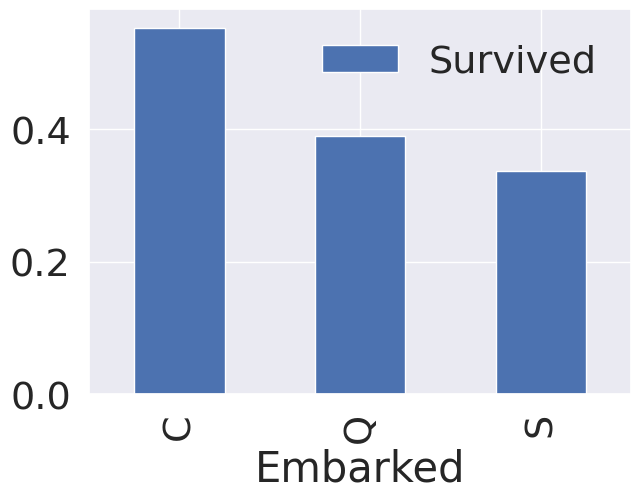

In [30]:
# survival rate by port
f, ax = plt.subplots(1, 1, figsize=(7, 5))

df_train[['Embarked', 'Survived']].groupby('Embarked', 
           as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax)
plt.show()

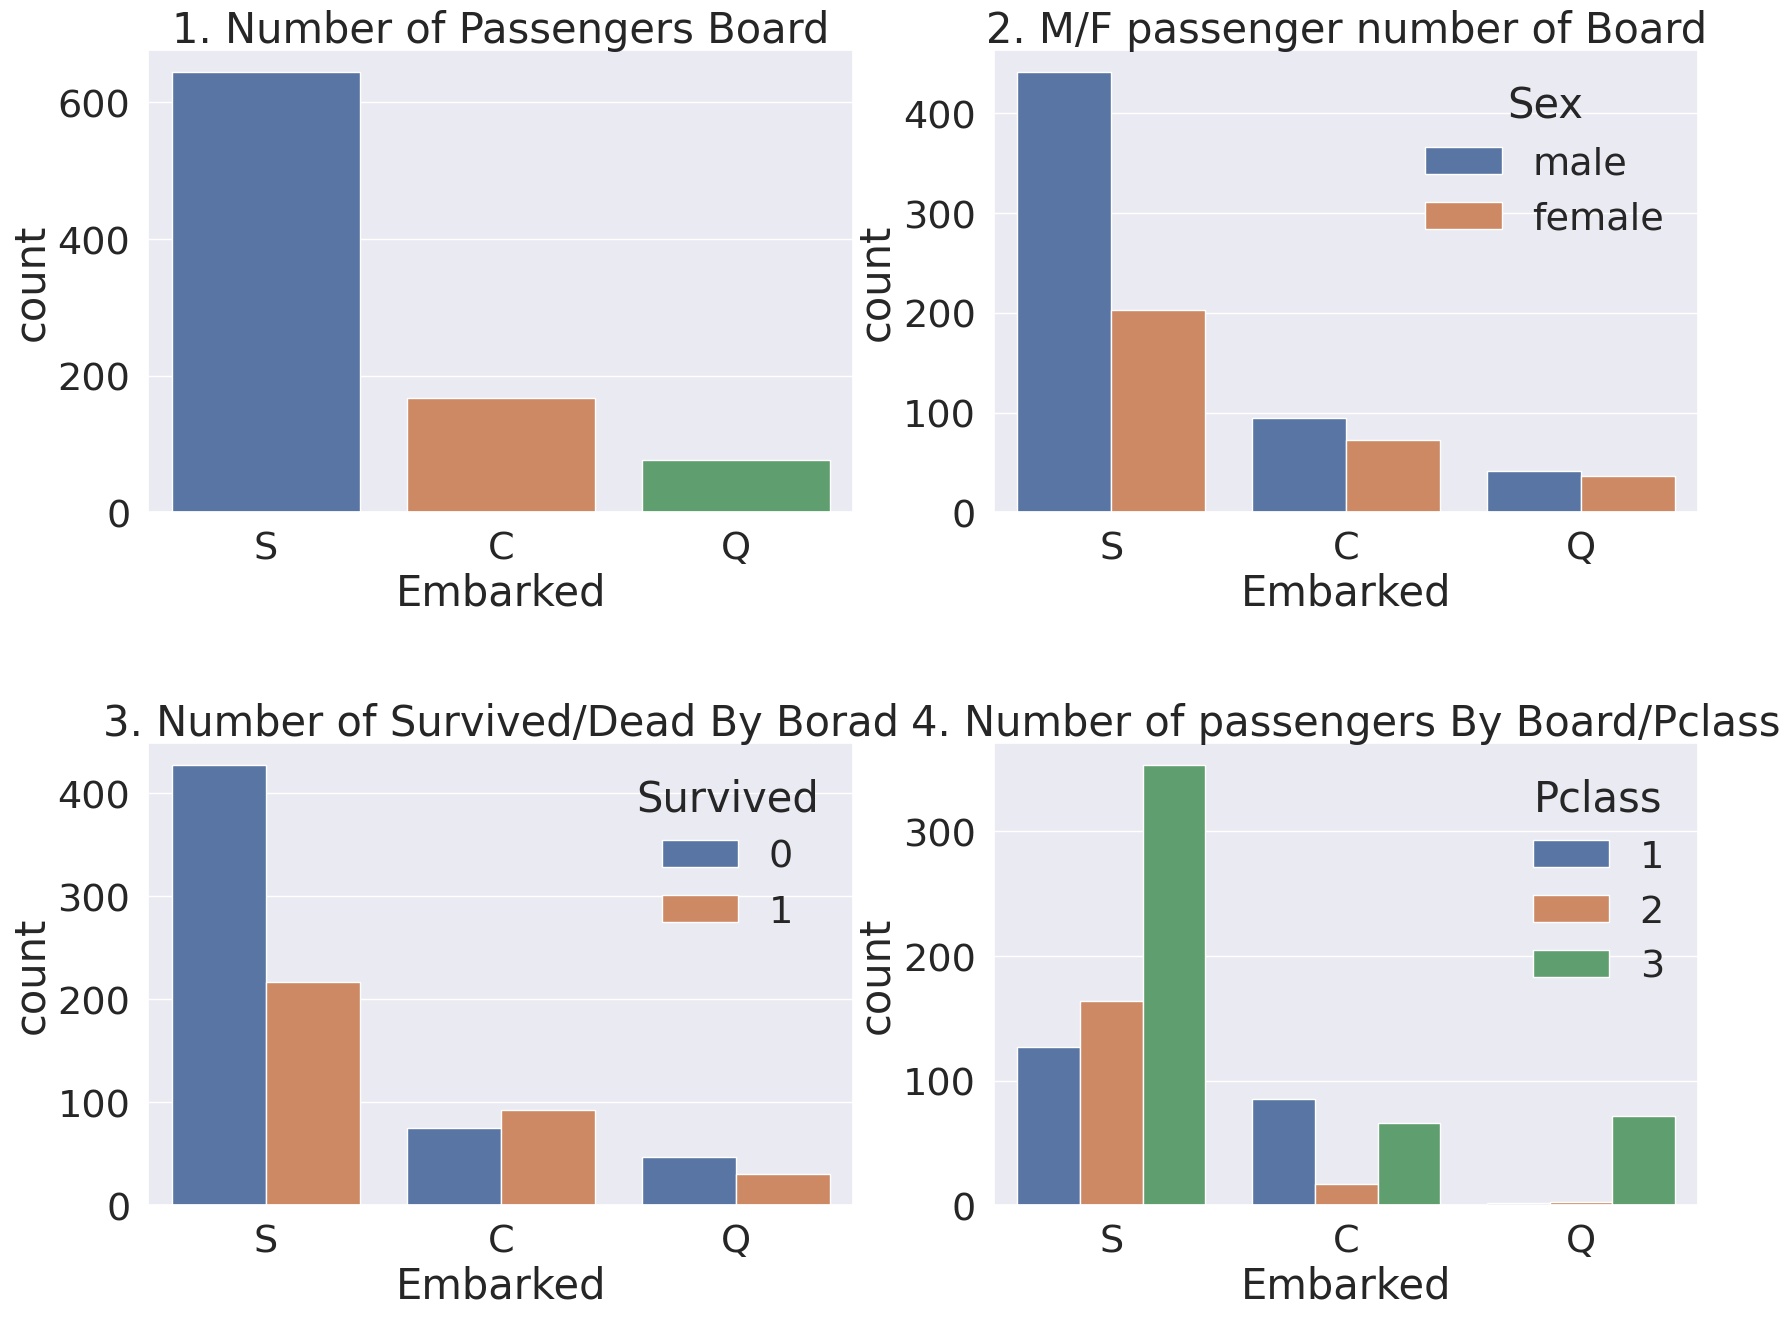

In [31]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.countplot(x='Embarked', data=df_train, ax=ax[0, 0])
sns.countplot(x='Embarked', hue='Sex', data=df_train, ax=ax[0, 1])
sns.countplot(x='Embarked', hue='Survived', data=df_train, ax=ax[1, 0])
sns.countplot(x='Embarked', hue='Pclass', data=df_train, ax=ax[1, 1])

#set_title
ax[0, 0].set_title("1. Number of Passengers Board")
ax[0, 1].set_title("2. M/F passenger number of Board")
ax[1, 0].set_title("3. Number of Survived/Dead By Borad")
ax[1, 1].set_title("4. Number of passengers By Board/Pclass")

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()  

- Most people boarded at S Port
- C/Q has a similar male to female ratio, and S Port has more than twice as many male passengers.
- S has the largest number of survivors, but the survival rate is the lowest (due to the large number of male passengers)
- Among S passengers, there are many low-class passengers, while C has many high-class passengers.
- This confirmed that C had the highest survival rate.

### 2.6. Family Number - SibSp + Parch

In [32]:
df_train['Family'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['Family'] = df_test['SibSp'] + df_test['Parch'] + 1

In [33]:
print(f"max number of Family: {df_train['Family'].max()}")
print(f"min number of Family: {df_train['Family'].min()}")
print(f"mean number of Family: {df_train['Family'].mean():.2f}")

max number of Family: 11
min number of Family: 1
mean number of Family: 1.90


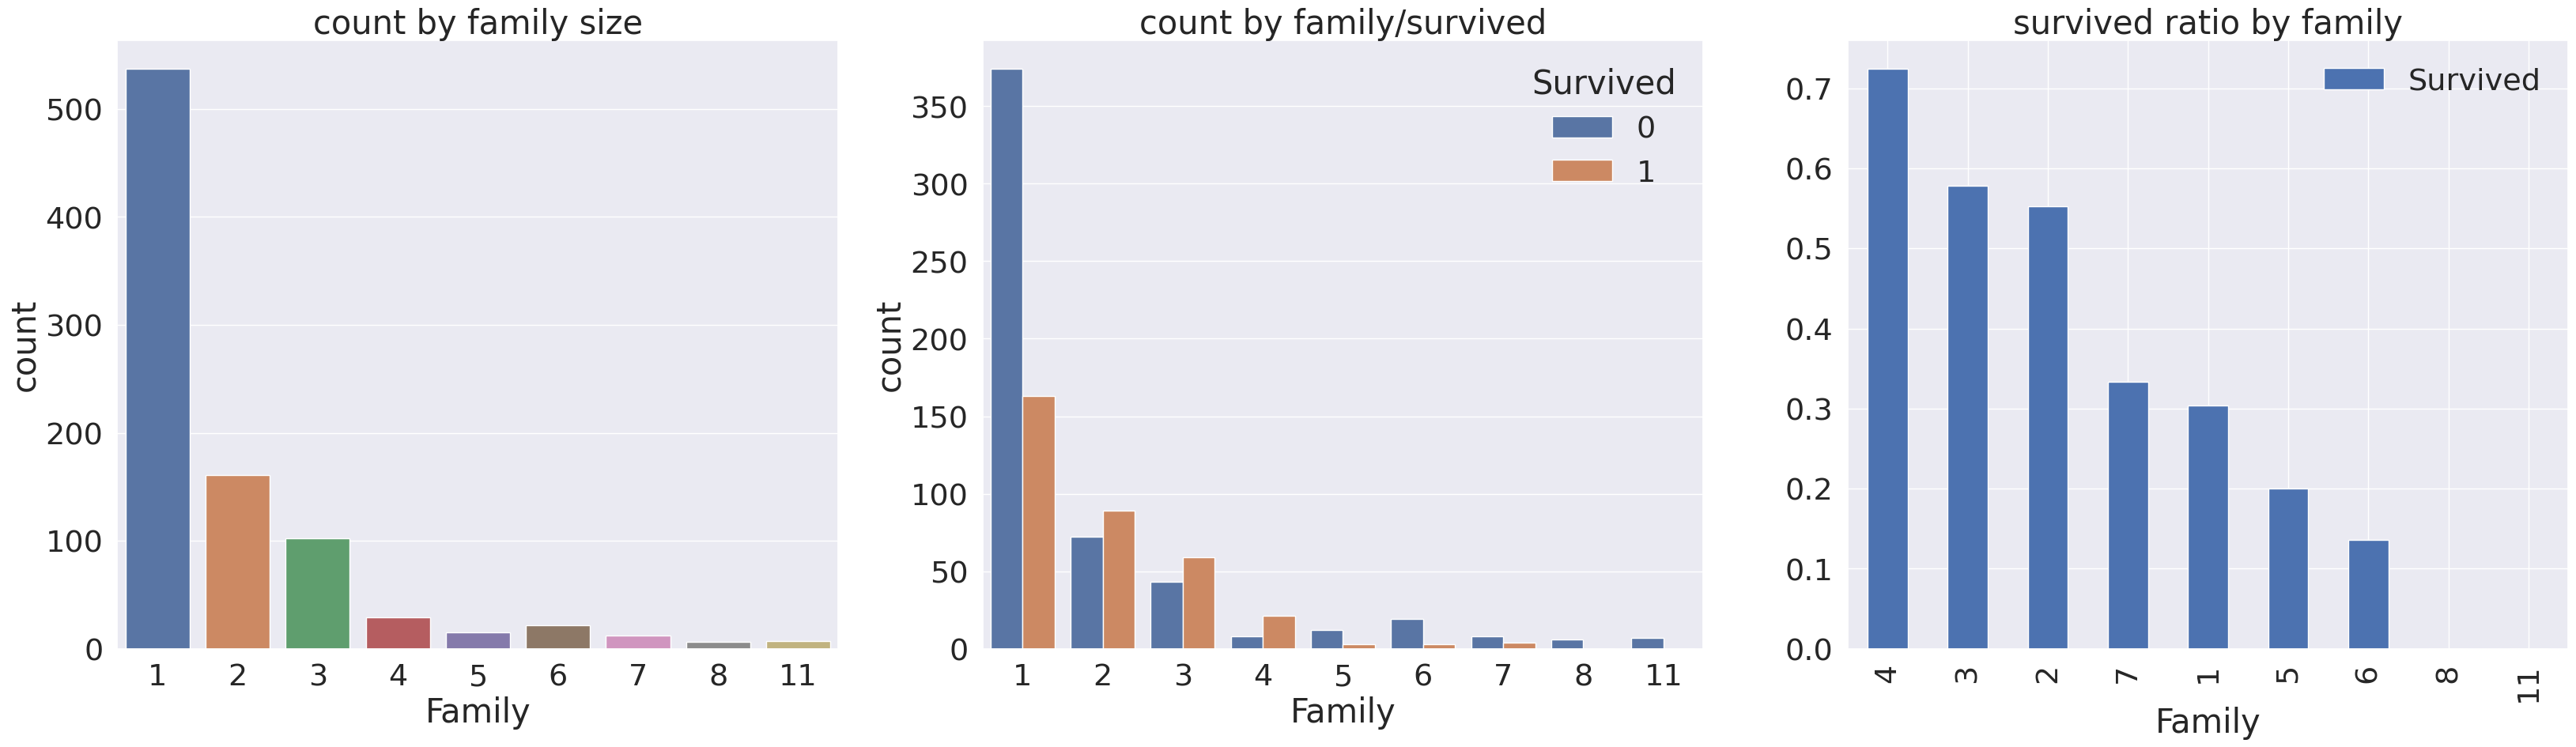

In [34]:
f, ax = plt.subplots(1, 3, figsize=(40, 10))

sns.countplot(x='Family', data=df_train, ax=ax[0])
sns.countplot(x='Family', hue='Survived', data=df_train, ax=ax[1])

df_train[['Family', 'Survived']].groupby('Family', 
         as_index=True).mean().sort_values(by='Survived', 
         ascending=False).plot.bar(ax=ax[2])

#set title
ax[0].set_title("count by family size")
ax[1].set_title("count by family/survived")
ax[2].set_title("survived ratio by family")

plt.show()

- The number of single-person households is overwhelmingly high.
- Family members of four have the highest survival rate.
- If the family is too small or too large, the mortality rate is high.

### 2.7. Fare

In [35]:
print(f"max Fare : {df_train['Fare'].max()}")
print(f"min Fare : {df_train['Fare'].min()}")
print(f"mean Fare : {df_train['Fare'].mean():.2f}")

max Fare : 512.3292
min Fare : 0.0
mean Fare : 32.20


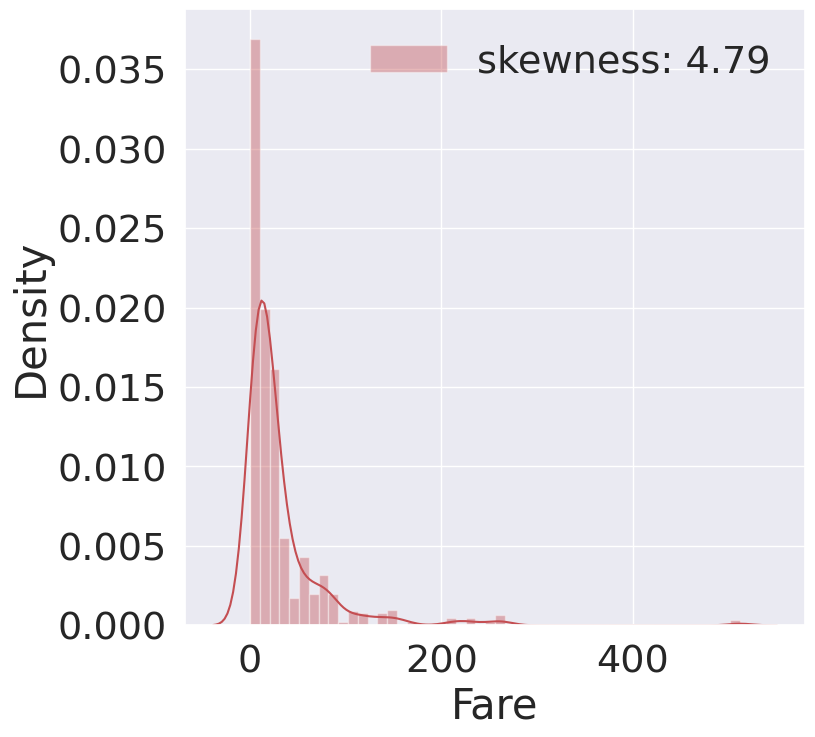

In [36]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.distplot(df_train['Fare'], color='r', label=f"skewness: {df_train['Fare'].skew():.2f}", 
             ax=ax)
ax.legend(loc='best')
plt.show()

In [37]:
# Since the skewness is biased to the left, log for normalization: 0 exception must be handled, so np.logx
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].median()
df_train['Fare'] = df_train['Fare'].map(lambda x: np.log(x) if x > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

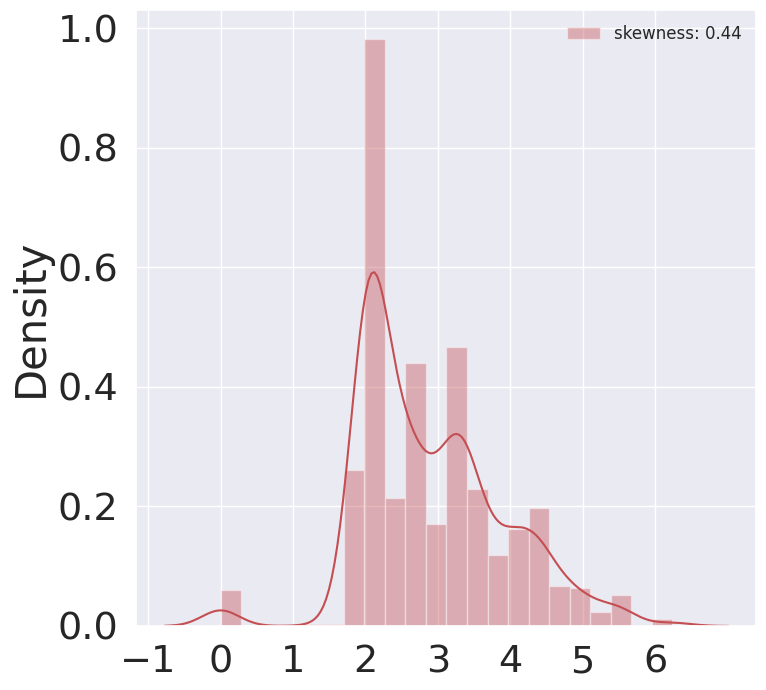

In [38]:
# log Alleviating asymmetry with processing
f, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.distplot(x=df_train['Fare'], color='r', label = 
            f"skewness: {df_train['Fare'].skew():.2f}", ax=ax)
ax.legend(loc='best', fontsize='12')
ax.set_xticks(np.arange(-1, 7, 1))
plt.show()

In [39]:
df_train['Fare'].describe()

count    891.000000
mean       2.893846
std        1.002899
min        0.000000
25%        2.068177
50%        2.670985
75%        3.433987
max        6.238967
Name: Fare, dtype: float64

### 7. Ticket 
- Carbin - Silver; Null - Excluded because the ratio is high

In [40]:
df_train['Ticket'].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [41]:
# new visualization lib import
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

py.init_notebook_mode(connected=True)

## 3. Feature engineering
### 3.1. Fill Null
#### 3.1.1. Age

In [42]:
# fill Age of Null using name(title)
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')
df_train['Initial'].value_counts()

Initial
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

In [43]:
# Relationship between gender and name
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [44]:
pd.crosstab(df_test['Initial'], df_test['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Col,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
Sex,,,,,,,,,
female,0,1,0,0,78,0,72,1,0
male,2,0,1,21,0,240,0,0,2


In [45]:
df_train[df_train['Name'].str.contains('Gordon')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,3.678829,A16,C,2,Lady
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,4.041808,A20,C,2,Sir


In [46]:
new_title = {'Miss': ['Ms', 'Mlle'], 
             'Mrs': ['Mme', 'Countess', 'Dona'], 
             'Mr': ['Sir', 'Don'], 
             'Others': ['Dr', 'Capt', 'Col', 'Jonkheer', 'Major', 'Rev', 'Lady']}

In [47]:
for k in new_title.keys():
    df_train['Initial'].replace(new_title[k], k, inplace=True)
    df_test['Initial'].replace(new_title[k], k, inplace=True)

In [48]:
df_train[['Survived', 'Pclass', 'Age', 'Fare', 'Family', 'Initial']].groupby('Initial').mean()

,Survived,Pclass,Age,Fare,Family
Initial,,,,,
Master,0.575000,2.625000,4.574167,3.340710,4.675000
Miss,0.702703,2.291892,21.845638,3.117688,2.243243
Mr,0.157996,2.404624,32.428750,2.633816,1.441233
Mrs,0.795276,1.984252,35.763636,3.448157,2.503937
Others,0.300000,1.400000,46.315789,3.157505,1.450000


<Figure size 1500x700 with 0 Axes>

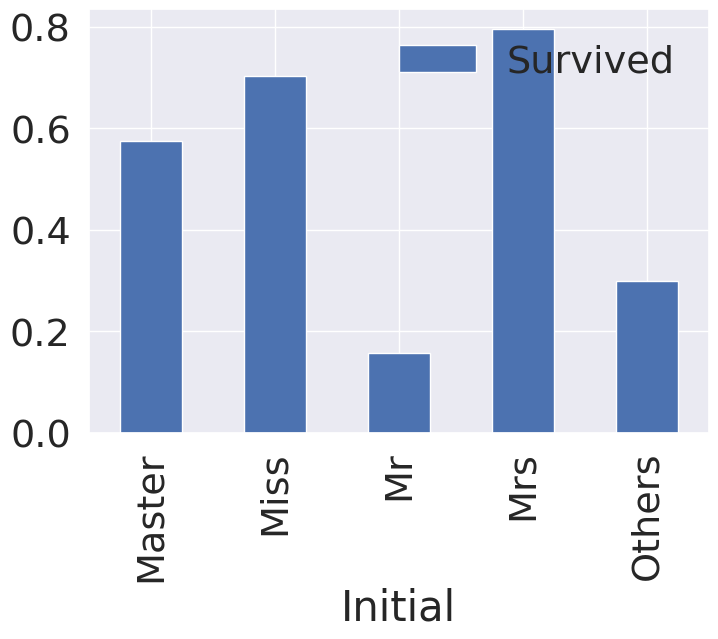

In [49]:
plt.figure(figsize=(15, 7))
df_train[['Survived', 'Initial']].groupby('Initial').mean().plot.bar()
plt.show()

In [50]:
# df_train as avg of each name, null value substitution: mean -> median  because of underfiting
tmp = df_train[['Initial', 'Age']].groupby('Initial').median()

In [51]:
for i in range(len(tmp)):
    df_train.loc[(df_train.Age.isnull())&(df_train.Initial == tmp.index[i]), 
                'Age'] = np.round(tmp.values[i][0])
    df_test.loc[(df_test.Age.isnull())&(df_test.Initial == tmp.index[i]), 
                'Age'] = np.round(tmp.values[i][0])

# def age_c(df):
#     md = df[['Pclass', 'Age']].groupby('Pclass').median()
#     for i in range(len(md)):
#         df.loc[(df.Age.isnull())&(df.Pclass == md.index[i]), 
#                'Age'] = np.round(md.values[i][0])
#     return df

# df_train['Age'] = age_c(df_train)['Age']
# df_test['Age'] = age_c(df_test)['Age']


# i_m = df_train[['Initial', 'Age']].groupby('Initial').mean()
# i_std = df_train[['Initial', 'Age']].groupby('Initial').std()

# i_mean = pd.concat([i_m, i_std], axis=1).reset_index().set_index('Initial')
# i_mean.columns = ['mean', 'std']
# i_mean['up'] = i_mean['mean'] - i_mean['std']
# i_mean['down'] = i_mean['mean'] + i_mean['std']

# def fill_age(row):
#     if pd.isnull(row['Age']):
#         return np.round(np.random.uniform(i_mean.loc[row['Initial']]['down'], i_mean.loc[row['Initial']]['up']), 2)
#     else:
#         return row['Age']

# df_train['Age'] = df_train.apply(fill_age, axis=1)
# df_test['Age'] = df_test.apply(fill_age, axis=1)


# data = [df_train, df_test]

# for dataset in data:
#     mean = df_train["Age"].mean()
#     std = df_test["Age"].std()
#     is_null = dataset["Age"].isnull().sum()
#     # compute random numbers between the mean, std and is_null
#     rand_age = np.random.randint(mean - std, mean + std, size = is_null)
#     # fill NaN values in Age column with random values generated
#     age_slice = dataset["Age"].copy()
#     age_slice[np.isnan(age_slice)] = rand_age
#     dataset["Age"] = age_slice
#     dataset["Age"] = df_train["Age"].astype(int)
# df_train["Age"].isnull().sum()
# df_test['Age'].isnull().sum()

In [52]:
df_train[['Survived', 'Pclass', 'Age', 'Fare', 'Family', 'Initial']].groupby('Initial').mean()

,Survived,Pclass,Age,Fare,Family
Initial,,,,,
Master,0.575000,2.625000,4.516750,3.340710,4.675000
Miss,0.702703,2.291892,21.681081,3.117688,2.243243
Mr,0.157996,2.404624,31.871869,2.633816,1.441233
Mrs,0.795276,1.984252,35.661417,3.448157,2.503937
Others,0.300000,1.400000,46.450000,3.157505,1.450000


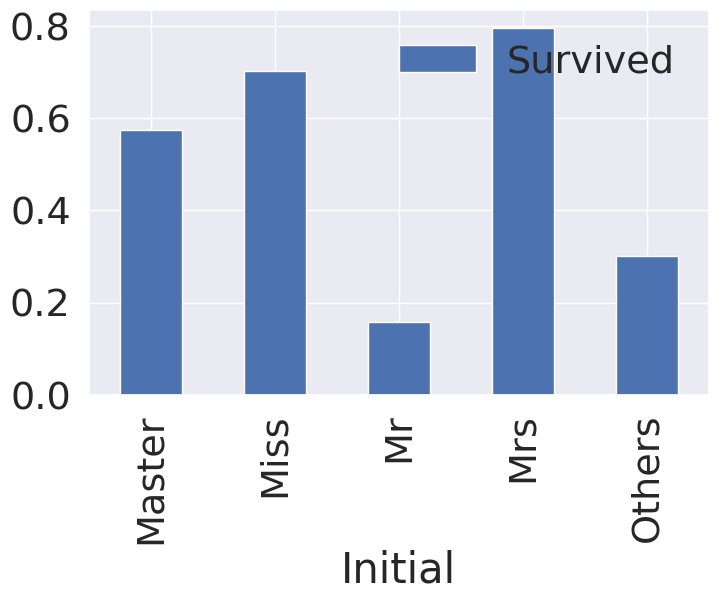

In [53]:
df_train[['Survived', 'Initial']].groupby('Initial').mean().plot.bar(figsize=(8, 5))
plt.show()

In [54]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,4.382027,B28,NaN,1,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,4.382027,B28,NaN,1,Mrs


In [55]:
# df_train[(df_train['Cabin'].notnull())&(df_train['Cabin'].str.contains('S'))].sort_values(by='Embarked')

#### 3.1.2. Embarked

In [56]:
# 최빈값
df_train['Embarked'].fillna('S', inplace=True)
df_test['Embarked'].fillna('S', inplace=True)

In [57]:
bins2 = pd.cut(df_train['Age'], bins=8)
bins2

0      (20.315, 30.263]
1       (30.263, 40.21]
2      (20.315, 30.263]
3       (30.263, 40.21]
4       (30.263, 40.21]
             ...       
886    (20.315, 30.263]
887    (10.368, 20.315]
888    (20.315, 30.263]
889    (20.315, 30.263]
890     (30.263, 40.21]
Name: Age, Length: 891, dtype: category
Categories (8, interval[float64, right]): [(0.34, 10.368] < (10.368, 20.315] < (20.315, 30.263] < (30.263, 40.21] < (40.21, 50.158] < (50.158, 60.105] < (60.105, 70.052] < (70.052, 80.0]]

### 3.2. Age format to Categorical : Spit it for now -> Use

In [58]:
df_train['new_Age'] = pd.cut(df_train['Age'], bins=8).cat.codes
df_test['new_Age'] = pd.cut(df_test['Age'], bins=bins2.cat.categories,labels=False).cat.codes

In [59]:
# fare
bins3 = pd.cut(df_train['Fare'], bins=5)
df_train['new_Fare'] = pd.cut(df_train['Fare'], bins=5).cat.codes
df_test['new_Fare'] = pd.cut(df_test['Fare'], bins=bins3.cat.categories, labels=False).cat.codes

In [60]:
bins3

0      (1.248, 2.496]
1      (3.743, 4.991]
2      (1.248, 2.496]
3      (3.743, 4.991]
4      (1.248, 2.496]
            ...      
886    (2.496, 3.743]
887    (2.496, 3.743]
888    (2.496, 3.743]
889    (2.496, 3.743]
890    (1.248, 2.496]
Name: Fare, Length: 891, dtype: category
Categories (5, interval[float64, right]): [(-0.00624, 1.248] < (1.248, 2.496] < (2.496, 3.743] < (3.743, 4.991] < (4.991, 6.239]]

In [61]:
def set_single(row):
    if row['Family'] > 1:
        return 0
    else:
        return 1
df_train['Single'] = df_train.apply(set_single, axis=1)
df_test['Single'] = df_test.apply(set_single, axis=1)

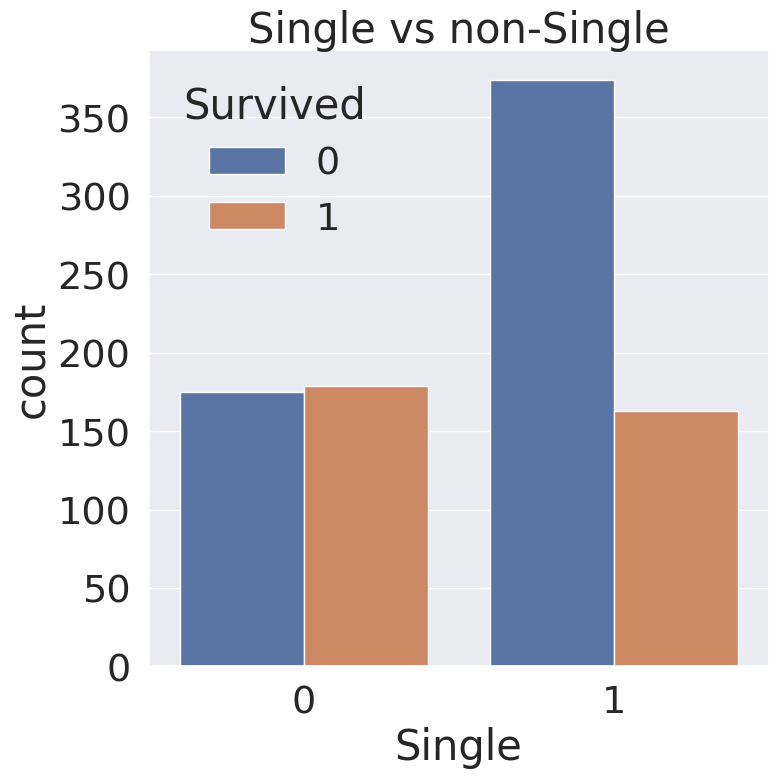

In [62]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.countplot(x='Single', data=df_train, hue='Survived', ax=ax)
ax.set_title('Single vs non-Single')
plt.show()

### 3.3. Initital/Embarked/Sex(Categorical) to (Number)

In [63]:
c_cols = ['Initial', 'Embarked', 'Sex']
c_vals = [['Master', 'Miss', 'Mr', 'Mrs', 'Others'], 
         ['S', 'C', 'Q'], 
         ['male', 'female']]

def C_to_Number(df, c_cols, c_vals): #df, c_cols no, c_value_list
    df_new = df.copy()
    for j in range(len(c_cols)):
        tmp_dic = {}
        for i in range(len(c_vals[j])):
            tmp_dic[c_vals[j][i]] = i
        df_new[c_cols[j]] = df[c_cols[j]].map(tmp_dic)
    return df_new

In [64]:
# train / test type convert
df_train = C_to_Number(df_train, c_cols, c_vals)
df_test = C_to_Number(df_test, c_cols, c_vals)

In [65]:
df_train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked       False
Family         False
Initial        False
new_Age        False
new_Fare       False
Single         False
dtype: bool

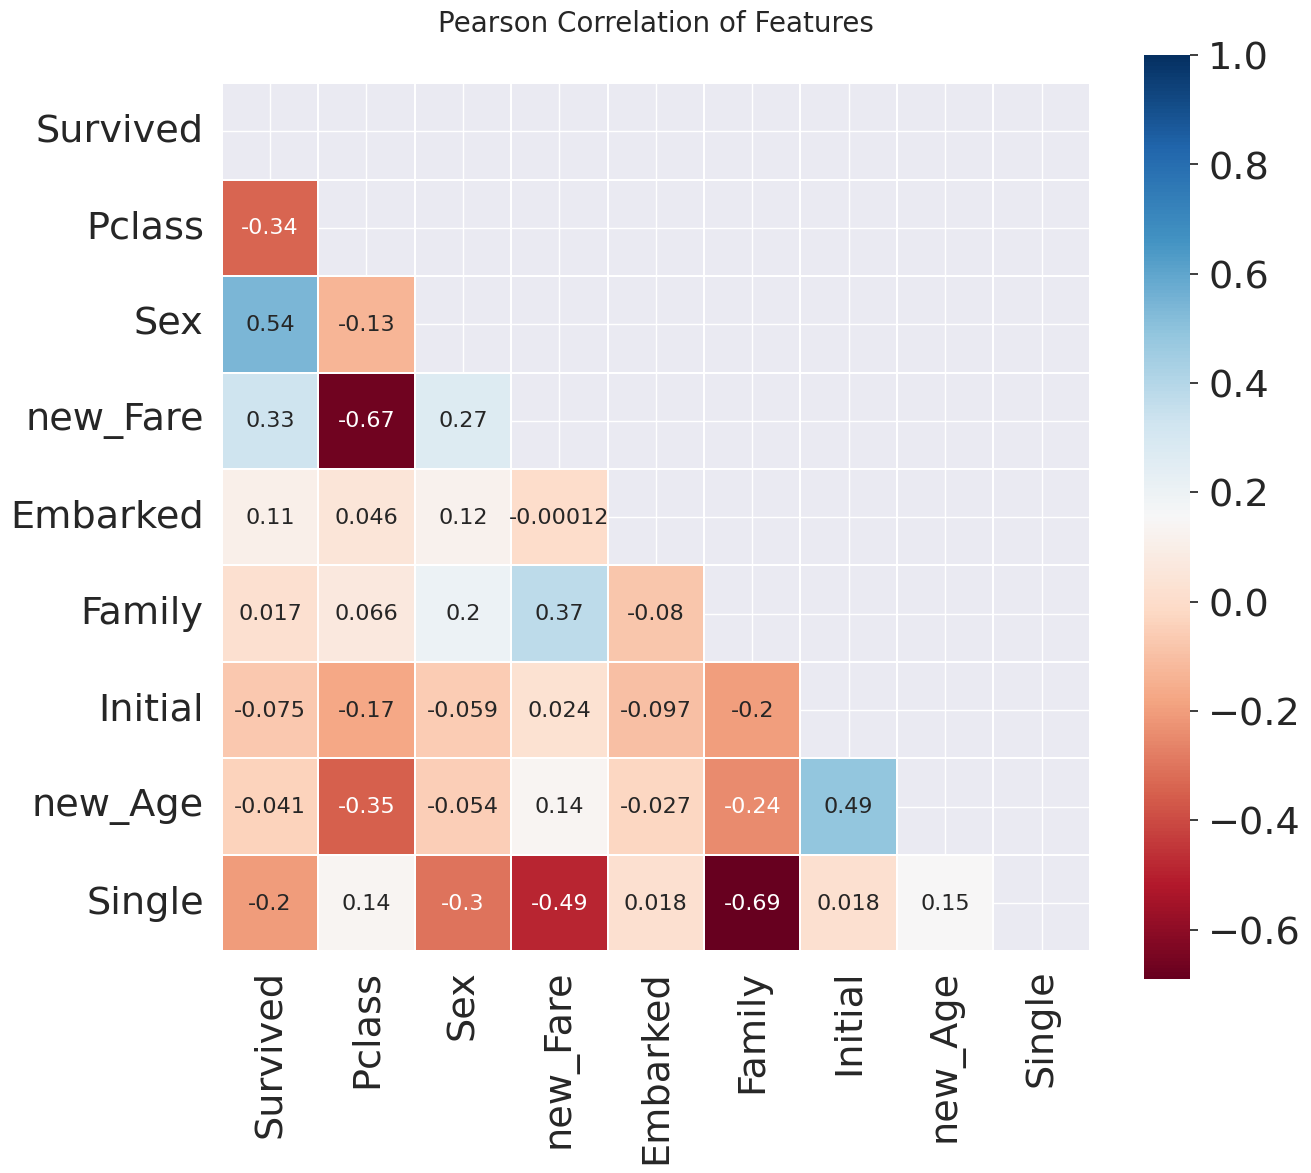

In [66]:
# draw heatmap

heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'new_Fare', 
                        'Embarked', 'Family', 'Initial', 'new_Age', 'Single']]

#half
corr = heatmap_data.astype(float).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

colormap = plt.cm.RdBu

plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(corr, mask=mask, linewidths=0.1, vmax=1.0, 
           square=True, cmap=colormap, linecolor='white', annot=True, 
           annot_kws={'size':16})
del heatmap_data

- +/- 0.7 이상이면 상관관계가 있다고 가정한다면, 
- 해당되는 feature 없음


## 4. Data Preprocessing
### 4.1. One-hot encoding on Categorical Data

In [67]:
#deck
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [df_train, df_test]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
df_train = df_train.drop(['Cabin'], axis=1)
df_test = df_test.drop(['Cabin'], axis=1)

In [68]:
c_cols = ['Pclass', 'Sex', 'Embarked', 'Initial', 'new_Age', 'new_Fare', 'Single', 'Deck']
def convert_onehot(df, c_cols):
    df_new = df.copy()
    for col in c_cols:
        df_new = pd.get_dummies(df_new, columns=[col], prefix=col, dtype=np.int64, drop_first=True)
    return df_new

In [69]:
# train_set = convert_onehot(df_train, c_cols)
# test_set = convert_onehot(df_test, c_cols)

In [70]:
x_columns = ['Pclass', 'Sex', 'Embarked', 'Family', 'Initial', 'new_Age', 'new_Fare', 'Single', 'Deck']
# x_columns = ['Family', 'Pclass_2', 'Pclass_3', 'Sex_1', 'Embarked_1',
#              'Embarked_2', 'Initial_1', 'Initial_2', 'Initial_3', 'Initial_4',
#              'new_Age_1', 'new_Age_2', 'new_Age_3', 'new_Age_4', 'new_Age_5',
#              'new_Age_6', 'new_Age_7', 'new_Fare_1', 'new_Fare_2', 'new_Fare_3',
#              'new_Fare_4', 'Single_1', 'Deck_1', 'Deck_2', 'Deck_3', 'Deck_4',
#              'Deck_5', 'Deck_6', 'Deck_7', 'Deck_8']
y_columns = 'Survived'

# train/test_set tunn
train_x = df_train[x_columns]
train_y = df_train[y_columns]
test_x = df_test[x_columns]

In [71]:
train_x.head()
train_x.shape

(891, 9)

In [72]:
total = pd.concat([train_x, test_x], axis=0)
total

,Pclass,Sex,Embarked,Family,Initial,new_Age,new_Fare,Single,Deck
0,3,0,0,2,2,2,1,0,8
1,1,1,1,2,3,3,3,0,3
2,3,1,0,1,1,2,1,1,8
3,1,1,0,2,3,3,3,0,3
4,3,0,0,1,2,3,1,1,8
...,...,...,...,...,...,...,...,...,...
413,3,0,0,1,2,2,1,1,8
414,1,1,1,1,3,3,3,1,3
415,3,0,0,1,2,3,1,1,8
416,3,0,0,1,2,2,1,1,8


In [73]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

scaler.fit(total)

X = pd.DataFrame(scaler.transform(total), columns=total.columns)
X

,Pclass,Sex,Embarked,Family,Initial,new_Age,new_Fare,Single,Deck
0,0.841916,-0.743497,-0.603436,0.073352,0.133412,-0.274673,-0.943373,-1.233758,0.509153
1,-1.546098,1.344995,0.927373,0.073352,1.417501,0.482267,1.390984,-1.233758,-1.912654
2,0.841916,1.344995,-0.603436,-0.558346,-1.150677,-0.274673,-0.943373,0.810532,0.509153
3,-1.546098,1.344995,-0.603436,0.073352,1.417501,0.482267,1.390984,-1.233758,-1.912654
4,0.841916,-0.743497,-0.603436,-0.558346,0.133412,0.482267,-0.943373,0.810532,0.509153
...,...,...,...,...,...,...,...,...,...
1304,0.841916,-0.743497,-0.603436,-0.558346,0.133412,-0.274673,-0.943373,0.810532,0.509153
1305,-1.546098,1.344995,0.927373,-0.558346,1.417501,0.482267,1.390984,0.810532,-1.912654
1306,0.841916,-0.743497,-0.603436,-0.558346,0.133412,0.482267,-0.943373,0.810532,0.509153
1307,0.841916,-0.743497,-0.603436,-0.558346,0.133412,-0.274673,-0.943373,0.810532,0.509153


In [74]:
train_x = X[:len(df_train)]
test_x = X[len(df_train):]
len(train_x), len(test_x)

(891, 418)

In [75]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)


train_x_r, train_y_r = smote.fit_resample(train_x, train_y)

In [76]:
train_x_r.shape, train_y_r.shape

((1098, 9), (1098,))

<Axes: xlabel='Survived'>

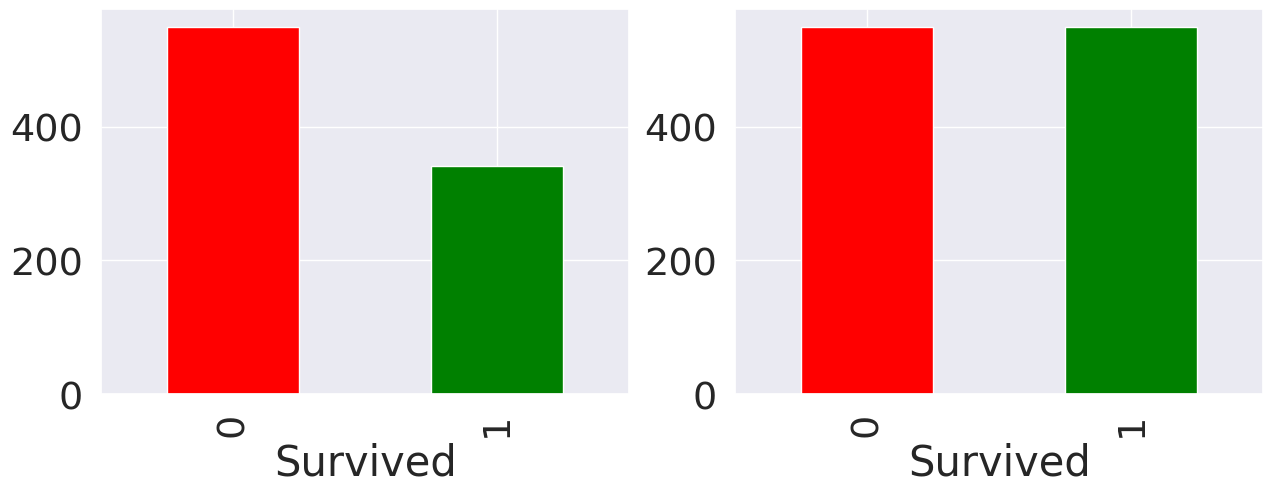

In [77]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))

train_y.value_counts().plot(kind='bar', ax=ax[0], color=['red', 'green'])
train_y_r.value_counts().plot(kind='bar', ax=ax[1], color=['red', 'green'])

## ML/DLL As a model result...
- Train/test set underfitting and public score measured as low as 0.779
- I tried converting the randomforest model hyperparameters, which generally show decent performance, but there was no change in performance.
- New feature addition and feature engineering required

## 5. Modeling
### 5.1. ML

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [79]:
# devide to train/valid set

x_train, x_valid, y_train, y_valid = train_test_split(train_x_r, train_y_r, test_size=0.2, random_state=42)

In [80]:
print(f"Train set shape : {x_train.shape} / {y_train.shape}")
print(f"Valid set shape : {x_valid.shape} / {y_valid.shape}")

Train set shape : (878, 9) / (878,)
Valid set shape : (220, 9) / (220,)


In [81]:
# model study & prediction
model_list = [RandomForestClassifier, svm, HistGradientBoostingClassifier, LogisticRegression, XGBClassifier]

df_result = pd.DataFrame(columns = ['model_name', 'train_act', 'valid_act', 'auc_score'])

def model_run(no):
    if no == 1:
        model = model_list[no].SVC()
    elif no == 3:
        model = model_list[no](max_iter=500)
    elif no == 0:
        rf_model = model_list[no]()
        param_grid = {'n_estimators': [500], 
                      'max_depth': [10, 20, 30],
                      'min_samples_split': [2, 4, 8],
                      'min_samples_leaf': [4, 12],
                      'max_features': ['auto', 'sqrt', 'log2']
                     }
        model = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
    elif no == 4:
        model = model_list[no](n_estimators=1000, max_depth=300, learning_rate=0.01, objective='binary:logistic')
    else:
        model = model_list[no]()
    model.fit(x_train, y_train)
    prediction = model.predict(x_valid)
    val_act = model.score(x_valid, y_valid)#metrics.accuracy_score(prediction, y_valid)
    train_act = model.score(x_train, y_train)
    auc_score = roc_auc_score(y_valid, prediction).round(3)
    df_result.loc[no] = [model_list[no].__name__, np.round(train_act, 2), np.round(val_act, 2), auc_score]
    
    print( '-'*10, model_list[no].__name__, '-'*10)
    print(f'train_accuracy: {train_act}, valid_accuracy: {val_act}')
    print(f"auc_score: {auc_score}")
    print(classification_report(y_valid, prediction))
    print(confusion_matrix(y_valid, prediction))
    
    return model

In [82]:
model0 = model_run(0) #randon forest
model1 = model_run(1) #svm
model2 = model_run(2) #histgradient
model3= model_run(3) #logistic regression
model4 = model_run(4) # xgboost

---------- RandomForestClassifier ----------
train_accuracy: 0.8553530751708428, valid_accuracy: 0.8545454545454545
auc_score: 0.855
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       103
           1       0.87      0.85      0.86       117

    accuracy                           0.85       220
   macro avg       0.85      0.85      0.85       220
weighted avg       0.85      0.85      0.85       220

[[ 88  15]
 [ 17 100]]
---------- sklearn.svm ----------
train_accuracy: 0.8382687927107062, valid_accuracy: 0.8454545454545455
auc_score: 0.843
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       103
           1       0.84      0.88      0.86       117

    accuracy                           0.85       220
   macro avg       0.85      0.84      0.84       220
weighted avg       0.85      0.85      0.85       220

[[ 83  20]
 [ 14 103]]
---------- HistGradientBoostingClassifier ---

In [83]:
model0.best_params_

{'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 500}

In [84]:
df_result

,model_name,train_act,valid_act,auc_score
0,RandomForestClassifier,0.86,0.85,0.855
1,sklearn.svm,0.84,0.85,0.843
2,HistGradientBoostingClassifier,0.91,0.84,0.839
3,LogisticRegression,0.80,0.79,0.784
4,XGBClassifier,0.91,0.83,0.833


In [85]:
test_x.describe()

,Pclass,Sex,Embarked,Family,Initial,new_Age,new_Fare,Single,Deck
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,-0.035022,0.015955,0.107035,-0.027901,0.016676,0.016876,0.047891,0.003576,0.013204
std,1.005160,1.005864,1.049394,0.959595,0.999302,0.989770,1.024856,1.000434,0.992181
min,-1.546098,-0.743497,-0.603436,-0.558346,-2.434766,-2.545492,-2.110551,-1.233758,-2.881376
25%,-1.546098,-0.743497,-0.603436,-0.558346,0.133412,-0.274673,-0.943373,-1.233758,0.509153
50%,0.841916,-0.743497,-0.603436,-0.558346,0.133412,-0.274673,0.223806,0.810532,0.509153
75%,0.841916,1.344995,0.927373,0.073352,0.133412,0.482267,0.223806,0.810532,0.509153
max,0.841916,1.344995,2.458182,5.758637,2.701590,3.510027,2.558163,0.810532,0.509153


In [86]:
train_x.describe()

,Pclass,Sex,Embarked,Family,Initial,new_Age,new_Fare,Single,Deck
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.016430,-0.007485,-0.050214,0.013089,-0.007824,-0.007917,-0.022468,-0.001677,-0.006194
std,0.998275,0.998279,0.973095,1.019219,1.001354,1.005777,0.988475,1.000915,1.004702
min,-1.546098,-0.743497,-0.603436,-0.558346,-2.434766,-1.788552,-2.110551,-1.233758,-3.365737
25%,-0.352091,-0.743497,-0.603436,-0.558346,-1.150677,-0.274673,-0.943373,-1.233758,0.509153
50%,0.841916,-0.743497,-0.603436,-0.558346,0.133412,-0.274673,0.223806,0.810532,0.509153
75%,0.841916,1.344995,0.927373,0.073352,0.133412,0.482267,0.223806,0.810532,0.509153
max,0.841916,1.344995,2.458182,5.758637,2.701590,3.510027,2.558163,0.810532,0.509153


In [87]:
# # # HistGradientBoostingClassifier
# submission['Survived'] = model0.predict(test_x)
# submission

# submission.to_csv('./submission.csv', index=False)

### 5.2. Hyper parameter tunning 
- k fold validation 

### 5.3. Deep Learning model(3 layer model)

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [89]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(9, 64, bias=True)
        self.linear2 = nn.Linear(64, 8) 
        self.linear3 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu(self.linear(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.linear3(x))
        x = x.reshape(-1)
        return x
    
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.fc1 = nn.Linear(9, 128)
        self.fc2 = nn.Linear(128, 18)
        self.fc3 = nn.Linear(18, 128)
        self.output_layer = nn.Linear(128, 1)
        self.activation = nn.ReLU()  #nn.SiLU()  # Swish activation function
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        y = torch.sigmoid(self.output_layer(x))
        y = y.reshape(-1)
        return y

In [90]:
def training(epoches): 
    model = Model2()
    criterion = torch.nn.BCELoss() # cross-entropy loss
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    start = time.time()
    cost_r = [1]
    x_train_numpy = x_train.to_numpy()  # or x_train.values
    y_train_numpy = torch.Tensor(y_train.to_numpy())  # or y_train.values
    for epoch in range(epoches):     
        prediction = model(torch.Tensor(x_train_numpy))
        cost = criterion(prediction,  y_train_numpy)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        cost_r.append(np.sum(cost.detach().cpu().numpy()))
        if epoch % 1000 == 0 : 
            print(f"epoch: {epoch}/{epoches}, Cost: {cost:.6f}")
    end = time.time()
    print("time taken: ", end-start)
    plt.figure(figsize=(10, 5))
    plt.fontsize='12'
    plt.plot(cost_r)
#         plt.xticks(np.arange(0, epoches+1, 1000))
    plt.yticks(np.arange(0, 1.1, 0.2))
    plt.xlabel('epoch')
    plt.ylabel('cost')
    return model
    
def result(model, x, y, title):
    x = x.to_numpy()
    y = y.to_numpy()
    with torch.no_grad():
        hypothesis = model(torch.Tensor(x)) # 모델에 x값 입력하여 sigmoid 출력
        predicted = (hypothesis > 0.5).float() # sigmoid 출력값이 0.5 이상이면 출력
        accuracy = (predicted == torch.Tensor(y)).float().mean()
        print(f"{title} : Accuracy: {np.round(accuracy.item(), 2)*100} %")
        print(f"auc_score: {roc_auc_score(y, predicted)}")
        if title == "valid":
            print(classification_report(y_valid, predicted))
            print(confusion_matrix(y_valid, predicted))

epoch: 0/10000, Cost: 0.703095
epoch: 1000/10000, Cost: 0.357607
epoch: 2000/10000, Cost: 0.293164
epoch: 3000/10000, Cost: 0.242941
epoch: 4000/10000, Cost: 0.224792
epoch: 5000/10000, Cost: 0.215350
epoch: 6000/10000, Cost: 0.210362
epoch: 7000/10000, Cost: 0.204604
epoch: 8000/10000, Cost: 0.201429
epoch: 9000/10000, Cost: 0.194041
소요시간:  31.765172243118286
train : 정확도(Accuracy): 91.0 %
auc_score: 0.9083883491114433
valid : 정확도(Accuracy): 82.0 %
auc_score: 0.8209277238403452
              precision    recall  f1-score   support

           0       0.77      0.86      0.82       103
           1       0.87      0.78      0.82       117

    accuracy                           0.82       220
   macro avg       0.82      0.82      0.82       220
weighted avg       0.82      0.82      0.82       220

[[89 14]
 [26 91]]


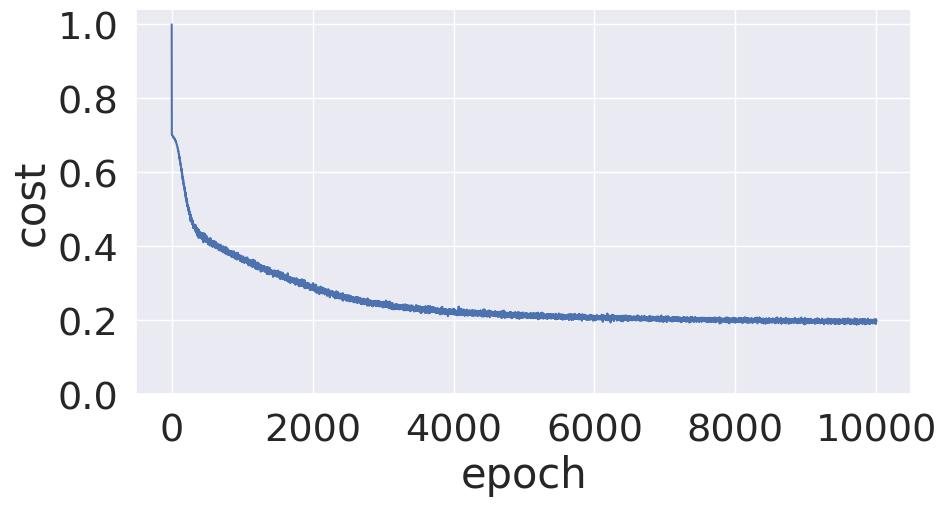

In [91]:
model_deep = training(10000)
result(model_deep, x_train, y_train, "train")
result(model_deep, x_valid, y_valid, "valid")

In [92]:
a = (model_deep(torch.Tensor(x_valid.to_numpy())) > 0.5).int()

c = pd.DataFrame({'idx': y_valid.index, 
                 'pred': a, 
                 'real': y_valid.values})

c
idxx = c.loc[c['pred'] != c['real'], 'idx']
idxx.values

array([  44,  570,  602,  107,  270,  247,  199,  677,  821,  208, 1050,
        273,  543,   10,  786,  962,   23,  501,   83,  711,  952,  156,
        220,  292,  323,  951,   39,  604,  100,  168,  192, 1068,  184,
        782,  351,  912])

In [93]:
len(x_valid.loc[x_valid.index.isin(idxx.values)])

36

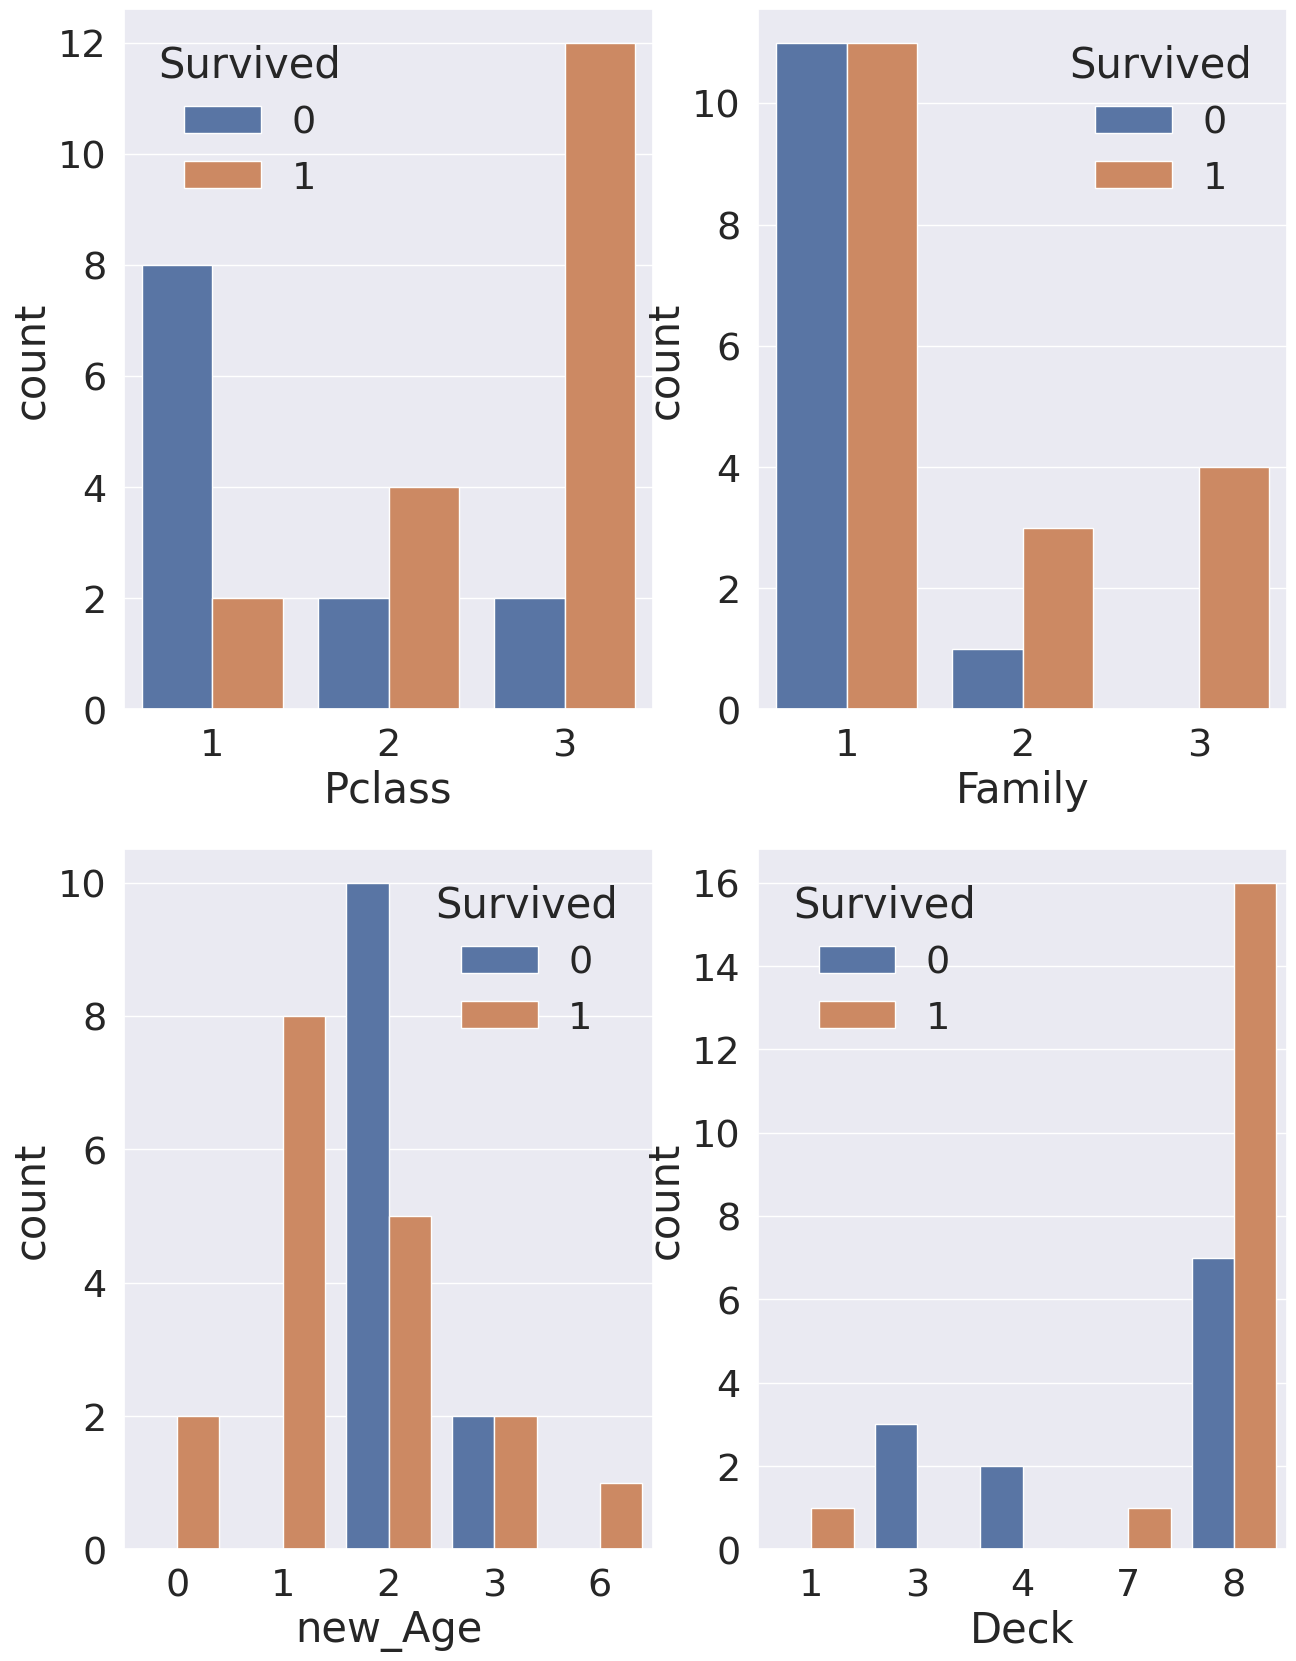

[(20.315, 30.263], (30.263, 40.21], (50.158, 60.105], (0.34, 10.368], (10.368, 20.315], (60.105, 70.052], (40.21, 50.158], (70.052, 80.0]]
Categories (8, interval[float64, right]): [(0.34, 10.368] < (10.368, 20.315] < (20.315, 30.263] < (30.263, 40.21] < (40.21, 50.158] < (50.158, 60.105] < (60.105, 70.052] < (70.052, 80.0]]


In [94]:
p_error = df_train.loc[df_train.index.isin(idxx.values)]


f, ax = plt.subplots(2, 2, figsize=(15, 20))

sns.countplot(x='Pclass', hue='Survived', data=p_error, ax=ax[0, 0])
sns.countplot(x='Family', hue='Survived', data=p_error, ax=ax[0, 1])
sns.countplot(x='new_Age', hue='Survived', data=p_error, ax=ax[1, 0])
sns.countplot(x='Deck', hue='Survived', data=p_error, ax=ax[1, 1])

plt.show()

print(bins2.unique())

In [95]:
p_error.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family,Initial,new_Age,new_Fare,Single,Deck
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",1,4.0,1,1,PP 9549,2.815409,0,3,1,0,2,0,7
23,24,1,1,"Sloper, Mr. William Thompson",0,28.0,0,0,113788,3.569533,0,1,2,2,2,1,1
39,40,1,3,"Nicola-Yarred, Miss. Jamila",1,14.0,1,0,2651,2.419630,1,2,1,1,1,0,8
44,45,1,3,"Devaney, Miss. Margaret Delia",1,19.0,0,0,330958,2.064226,2,1,1,1,1,1,8
83,84,0,1,"Carrau, Mr. Francisco M",0,28.0,0,0,113059,3.852273,0,1,2,2,3,1,8


### 5.4. feature importance view

In [96]:
# submission['Survived'] = (model_deep(torch.Tensor(test_x.to_numpy())) > 0.5).float()
# submission['Survived'] = submission['Survived'].astype(np.int64)
# submission
# submission.to_csv('./2submission.csv', index=False)

### 5.5. GNN(Graph NN)

In [97]:
!pip install  dgl -f https://data.dgl.ai/wheels/repo.html
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 56.1 MB/s eta 0:00:00
Looking in links: https://data.dgl.ai/wheels-test/repo.html
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.

In [98]:
import dgl
from dgl.nn import SAGEConv
import networkx as nx

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [99]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, num_classes, d_rate, aggregate_type='pool'):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats, aggregate_type)
        self.conv2 = SAGEConv(hidden_feats, num_classes, aggregate_type)
        self.dropout = nn.Dropout(d_rate)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv2(g, h)
        return h

In [100]:
# set mask
m_len = len(x_train)+len(x_valid)+len(test_x)
train_mask = np.zeros(m_len, dtype=bool)
train_mask[:len(x_train)] = True
valid_mask = np.zeros(m_len, dtype=bool)
valid_mask[len(x_train):len(x_train)+len(x_valid)] = True
test_mask = np.zeros(m_len, dtype=bool)
test_mask[len(x_train)+len(x_valid):] = True

#make dictionary array for edge
dic_array = np.zeros((m_len, m_len))

In [101]:
XX = pd.concat([x_train, x_valid, test_x], axis=0)
XX

,Pclass,Sex,Embarked,Family,Initial,new_Age,new_Fare,Single,Deck
2,0.841916,1.344995,-0.603436,-0.558346,-1.150677,-0.274673,-0.943373,0.810532,0.509153
6,-1.546098,-0.743497,-0.603436,-0.558346,0.133412,1.996147,1.390984,0.810532,-0.943931
578,0.841916,1.344995,0.927373,0.073352,1.417501,0.482267,0.223806,-1.233758,0.509153
636,0.841916,-0.743497,-0.603436,-0.558346,0.133412,0.482267,-0.943373,0.810532,0.509153
844,0.841916,-0.743497,-0.603436,-0.558346,0.133412,-1.031612,-0.943373,0.810532,0.509153
...,...,...,...,...,...,...,...,...,...
1304,0.841916,-0.743497,-0.603436,-0.558346,0.133412,-0.274673,-0.943373,0.810532,0.509153
1305,-1.546098,1.344995,0.927373,-0.558346,1.417501,0.482267,1.390984,0.810532,-1.912654
1306,0.841916,-0.743497,-0.603436,-0.558346,0.133412,0.482267,-0.943373,0.810532,0.509153
1307,0.841916,-0.743497,-0.603436,-0.558346,0.133412,-0.274673,-0.943373,0.810532,0.509153


In [102]:
# Adjacency matrix(for live) : each row's f simirarity ()  
# w = model0.estimator.fit(x_train, y_train).feature_importances_
# for i in range(len(XX)):
#     for j in range(len(XX)):
#         for n, k in enumerate(x_train.columns):
#             if XX.iloc[i][k] == XX.iloc[j][k]:
#                 dic_array[i][j] += w[n]
#     if i % 20 == 0:
#         print(f"idx: {i}, {i/len(XX):.2f} %")
dic_array = pd.read_csv('/kaggle/input/dataset-for-gnn-array/dic_array.csv').to_numpy()

In [103]:
from scipy.sparse import coo_matrix
#build graph
edge_index = torch.nonzero(torch.tensor(dic_array), as_tuple=False).T
g = dgl.graph((edge_index[1], edge_index[0]))
g.ndata['feature'] = torch.tensor(torch.tensor(XX.to_numpy()))
g.edata['weight'] = torch.tensor(coo_matrix(torch.tensor(dic_array)).data)

g = g.remove_self_loop().add_self_loop()

features = torch.tensor(XX.to_numpy()).float()
_= torch.tensor(np.zeros(len(test_x)))
labels = torch.tensor(pd.concat([y_train, y_valid], axis=0))
labels = torch.cat((labels, _), dim=0).long()
train_mask = torch.tensor(train_mask)
val_mask = torch.tensor(valid_mask)
test_mask = torch.tensor(test_mask)

In [104]:
#set hyperparameters
in_feats = features.shape[1]
hidden_feats = 64         
num_classes = 2
lr = 0.0005
num_epochs = 2000

In [105]:
#set model
model = GraphSAGE(in_feats, hidden_feats, num_classes, 0)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [106]:
# run model
for epoch in range(num_epochs):
    # forward
    model.train()
    logits = model(g, features)
    train_loss = criterion(logits[train_mask], labels[train_mask])

    # backward
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # validation
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            logits = model(g, features)
            val_loss = criterion(logits[val_mask], labels[val_mask])
            val_acc = (logits[val_mask].argmax(dim=1) == labels[val_mask]).float().mean().item()
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch: 0 | Train Loss: 1.0172 | Val Loss: 0.7286 | Val Acc: 0.5682
Epoch: 100 | Train Loss: 0.4801 | Val Loss: 0.4215 | Val Acc: 0.8091
Epoch: 200 | Train Loss: 0.4475 | Val Loss: 0.4089 | Val Acc: 0.7955
Epoch: 300 | Train Loss: 0.4278 | Val Loss: 0.4042 | Val Acc: 0.7955
Epoch: 400 | Train Loss: 0.4110 | Val Loss: 0.3983 | Val Acc: 0.8227
Epoch: 500 | Train Loss: 0.3985 | Val Loss: 0.3919 | Val Acc: 0.8227
Epoch: 600 | Train Loss: 0.3879 | Val Loss: 0.3879 | Val Acc: 0.8182
Epoch: 700 | Train Loss: 0.3779 | Val Loss: 0.3846 | Val Acc: 0.8273
Epoch: 800 | Train Loss: 0.3704 | Val Loss: 0.3853 | Val Acc: 0.8273
Epoch: 900 | Train Loss: 0.3641 | Val Loss: 0.3861 | Val Acc: 0.8318
Epoch: 1000 | Train Loss: 0.3582 | Val Loss: 0.3869 | Val Acc: 0.8273
Epoch: 1100 | Train Loss: 0.3530 | Val Loss: 0.3863 | Val Acc: 0.8318
Epoch: 1200 | Train Loss: 0.3479 | Val Loss: 0.3850 | Val Acc: 0.8318
Epoch: 1300 | Train Loss: 0.3427 | Val Loss: 0.3840 | Val Acc: 0.8318
Epoch: 1400 | Train Loss: 0.3379

In [107]:
model.eval()
with torch.no_grad():
    logits = model(g, features)
    predict_v = logits[val_mask].argmax(dim=1)
    print(f"auc_score: {roc_auc_score(labels[val_mask], predict_v)}")
    print(classification_report(labels[val_mask], predict_v))
    print(confusion_matrix(labels[val_mask], predict_v))
    predict_a = logits[test_mask].argmax(dim=1)
    submission['Survived'] = predict_a
    submission.to_csv('./submission.csv', index=False)

auc_score: 0.8490996597792715
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       103
           1       0.86      0.86      0.86       117

    accuracy                           0.85       220
   macro avg       0.85      0.85      0.85       220
weighted avg       0.85      0.85      0.85       220

[[ 86  17]
 [ 16 101]]
